In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPVisionModel, CLIPTextModel

import torchvision
from accelerate import Accelerator
from autoencoder import SparseAutoencoder, TopkSparseAutoencoder
from datalib import SafeTensorDataset

accelerator = Accelerator(mixed_precision="bf16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
vit = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14", attn_implementation="sdpa")
text = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", attn_implementation="sdpa")

# choose the SAE to load
# IMPORTANT: The SAE model must match the dataset dimensions!
# - For CLIP text embeddings (768D): use "cc3m-text-topk-lr-3e-4-k-4-expansion-4"
# - For FLUX transformer activations (3072D): use "cc3m-single_transformer_blocks.9"
# - For CLIP vision embeddings (1024D): use "cc3m-vision-topk-lr-3e-4-k-4-expansion-4"

# Since we're using "text" dataset (768D CLIP text embeddings), we need the text SAE
name = "cc3m-text-topk-lr-3e-4-k-4-expansion-4"
# If you want to use FLUX SAE, you need FLUX activations dataset instead:
# name = "cc3m-single_transformer_blocks.9"

model = TopkSparseAutoencoder.from_pretrained(f"RE-N-Y/{name}")

# run the model on sampled activations
# NOTE: "text" key contains 768D CLIP text embeddings
# For FLUX activations, you'd need a different dataset key
dataset = SafeTensorDataset("/mnt/drive_a/Projects/sae/data/cc3m/embeddings.safetensors", "text")

vit, text = torch.compile(vit), torch.compile(text)
dataloader = dataset.dataloader(batch_size=1024, num_workers=96, drop_last=True)
model, vit, dataloader = accelerator.prepare(model, vit, dataloader)


In [58]:
from tqdm import tqdm

# track topk inputs with highest activation for k-th hidden unit
topk = 16
pages = model.pages

topk_values = torch.zeros(pages, topk, dtype=torch.bfloat16, device="cpu")
topk_idxes = torch.full((pages, topk), -1, dtype=torch.int64, device="cpu")

# online topk algorithm
for bidx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    dictionary = model.encode(batch)

    _topk_values, _topk_idxes = torch.topk(dictionary.T, k=topk, dim=-1, sorted=True)
    _topk_idxes += bidx * 1024 # offset idxes to global idxes

    _topk_idxes = _topk_idxes.detach().cpu()
    _topk_values = _topk_values.detach().cpu()

    topk_idxes = torch.where(_topk_values > topk_values, _topk_idxes, topk_idxes)
    topk_values = torch.where(_topk_values > topk_values, _topk_values, topk_values)


# now you can use topk_idxes to get topk inputs, images, texts, from the dataset...

  0%|          | 0/2790 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

torch.Size([3072, 16])
torch.Size([3072, 16])


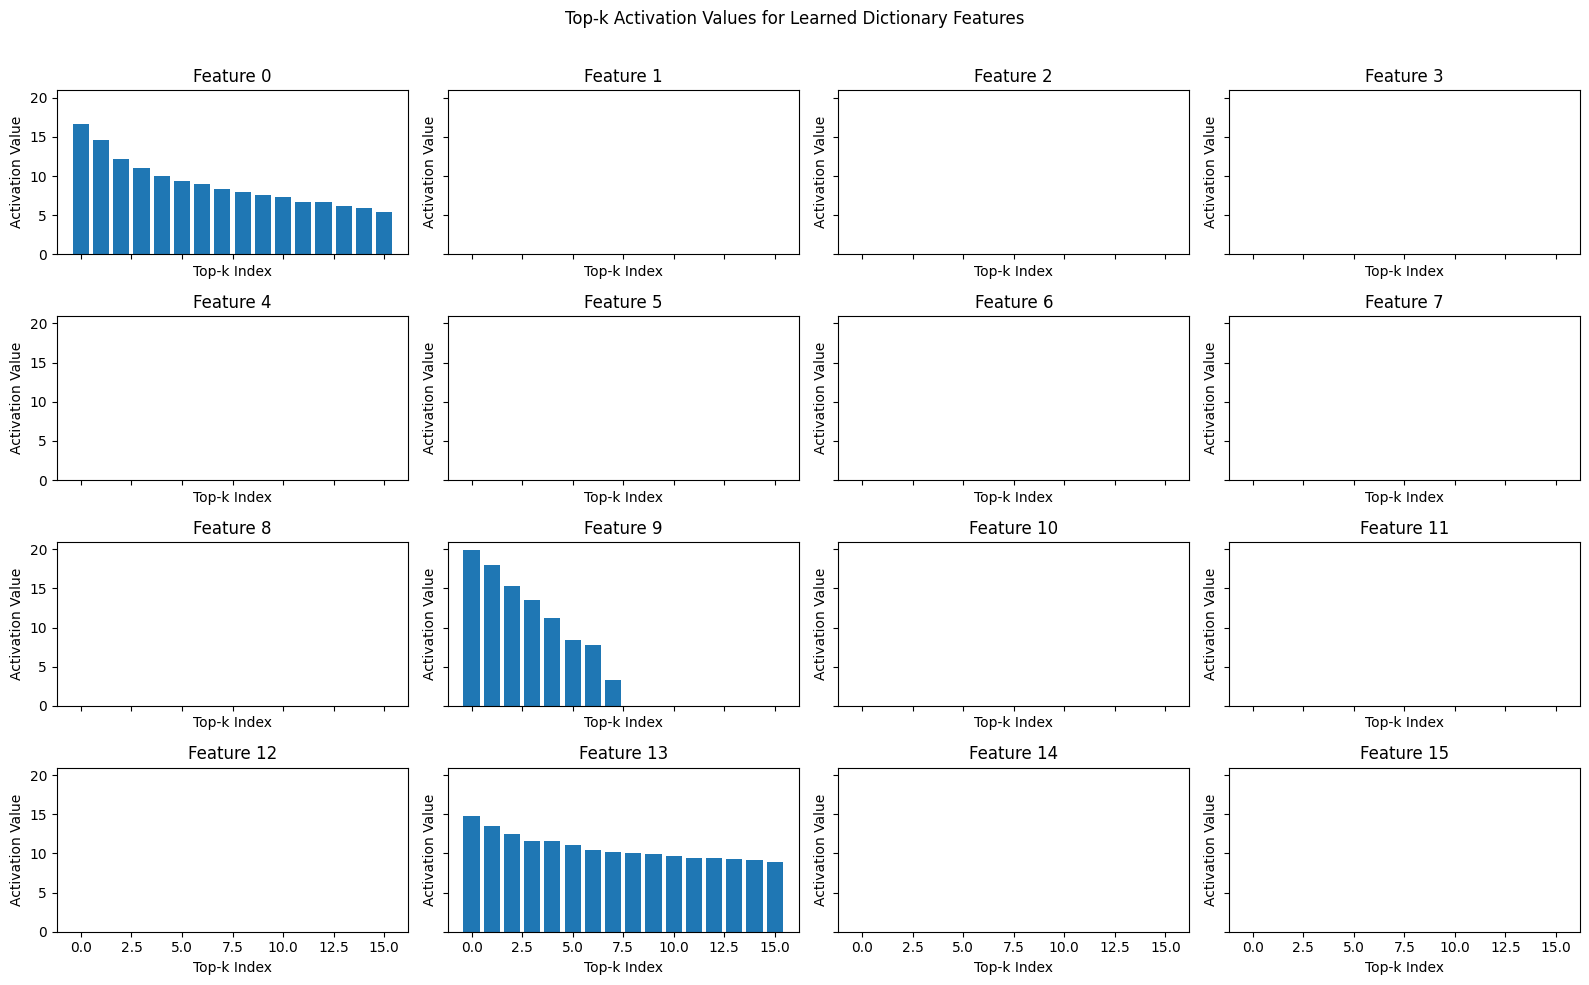

In [85]:
import matplotlib.pyplot as plt
import numpy as np

print(topk_idxes.shape)
print(topk_values.shape)

# Suppose this was a learned dictionary: visualize the top-k activation patterns for each hidden "feature"/page

fig, axs = plt.subplots(4, 4, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(min(16, model.pages)):
    # Visualize the distribution of topk activations for each "feature"/page
    axs[i].bar(np.arange(topk), topk_values[i].numpy())
    axs[i].set_title(f"Feature {i}")
    axs[i].set_xlabel("Top-k Index")
    axs[i].set_ylabel("Activation Value")

plt.suptitle("Top-k Activation Values for Learned Dictionary Features")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
from PIL import Image
from transformers import CLIPTextModel, CLIPVisionModel, AutoProcessor
from autoencoder import TopkSparseAutoencoder

vsae = TopkSparseAutoencoder.from_pretrained("RE-N-Y/cc3m-vision-topk-lr-3e-4-k-4-expansion-4")
# vsae = TopkSparseAutoencoder.from_pretrained("RE-N-Y/cc3m-siglip-vision-topk-lr-3e-4-k-16-expansion-128")
tsae = TopkSparseAutoencoder.from_pretrained("RE-N-Y/cc3m-text-topk-lr-3e-4-k-4-expansion-4")


vision = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")
text = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

image = Image.open("cat.jpg")
text_prompt = "a photo of a cat"

batch = processor(text=[text_prompt], images=[image], return_tensors="pt", truncation=True, padding=True)
vision_outputs = vision(pixel_values=batch["pixel_values"], output_hidden_states=True)
text_outputs = text(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])


tacts = text_outputs.pooler_output
vacts = vision_outputs.hidden_states[-2][:, 0, :]

# hidden states from SAE only topk activations are kept
# Use separate variables for vision and text encodings
v_hiddens = vsae.encode(vacts)
t_hiddens = tsae.encode(tacts)
print(v_hiddens.shape, t_hiddens.shape)

# decode the hidden states back to original activations
# Each SAE must decode its own encodings
v_reconstructed = vsae.decode(v_hiddens)
t_reconstructed = tsae.decode(t_hiddens)

# increase 12th activation by 42 and return the reconstructed activations
v_botched = vsae.surgery(vacts, k=12, strength=42.)
t_botched = tsae.surgery(tacts, k=12, strength=42.)

print(v_botched.shape, t_botched.shape)

torch.Size([1, 4096]) torch.Size([1, 3072])
torch.Size([1, 1024]) torch.Size([1, 768])


: 

Tensor shapes:
  vacts: torch.Size([1, 1024])
  tacts: torch.Size([1, 768])
  v_reconstructed: torch.Size([1, 1024])
  t_reconstructed: torch.Size([1, 768])
  v_botched: torch.Size([1, 1024])
  t_botched: torch.Size([1, 768])

Vision Reconstruction Metrics:
  Cosine Similarity: 0.9177
  L2 Distance: 7.2075
  Relative Error: 39.7833%

Text Reconstruction Metrics:
  Cosine Similarity: 0.7022
  L2 Distance: 20.4823
  Relative Error: 71.2748%

Surgery Effects (feature 12, strength 42):
  Vision embedding change (L2): 44.0287
  Text embedding change (L2): 46.4655

CLIP Vision-Text Similarity:
  Original: N/A (dimension mismatch)
  Reconstructed: N/A (dimension mismatch)
  Vision surgery only: N/A (dimension mismatch)
  Text surgery only: N/A (dimension mismatch)
  Both surgeries: N/A (dimension mismatch)


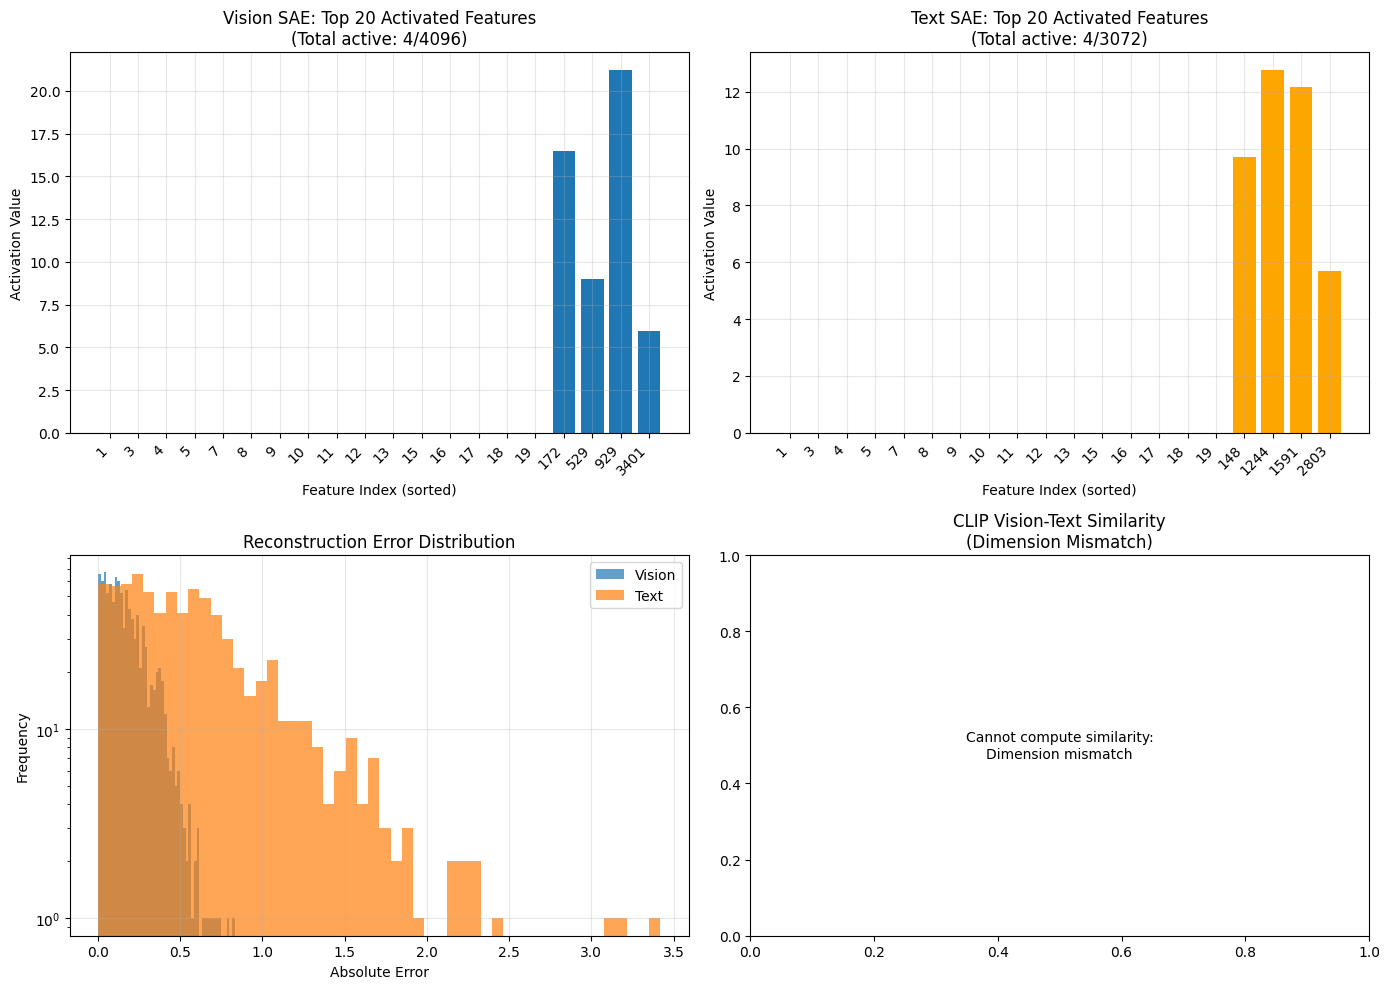


Summary:
  Vision SAE preserves 91.77% of information
  Text SAE preserves 70.22% of information
  Surgery on feature 12 changes embeddings by:
    Vision: 243.03% (relative)
    Text: 161.69% (relative)

  NOTE: Vision (1024D) and Text (768D) embeddings have different dimensions.
        CLIP similarity cannot be computed directly between hidden states.
        Use CLIP's projection layers to compare in the shared embedding space.


In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity

# Debug: Check shapes first
print("Tensor shapes:")
print(f"  vacts: {vacts.shape}")
print(f"  tacts: {tacts.shape}")
print(f"  v_reconstructed: {v_reconstructed.shape}")
print(f"  t_reconstructed: {t_reconstructed.shape}")
print(f"  v_botched: {v_botched.shape}")
print(f"  t_botched: {t_botched.shape}")

# Ensure tensors are on CPU for visualization (move to CPU if needed)
def to_cpu(tensor):
    """Move tensor to CPU if it's on a different device"""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu()
    return tensor

# Move all tensors to CPU for consistent processing
vacts = to_cpu(vacts)
tacts = to_cpu(tacts)
v_reconstructed = to_cpu(v_reconstructed)
t_reconstructed = to_cpu(t_reconstructed)
v_botched = to_cpu(v_botched)
t_botched = to_cpu(t_botched)
v_hiddens = to_cpu(v_hiddens)
t_hiddens = to_cpu(t_hiddens)

# Check for dimension mismatches
if vacts.shape != v_reconstructed.shape:
    print(f"WARNING: Vision dimension mismatch: {vacts.shape} vs {v_reconstructed.shape}")
if tacts.shape != t_reconstructed.shape:
    print(f"WARNING: Text dimension mismatch: {tacts.shape} vs {t_reconstructed.shape}")

# Compute metrics
def compute_metrics(original, reconstructed, name=""):
    """Compute reconstruction quality metrics"""
    cos_sim = cosine_similarity(original, reconstructed, dim=-1).item()
    l2_dist = torch.norm(original - reconstructed, dim=-1).item()
    l2_norm_original = torch.norm(original, dim=-1).item()
    relative_error = l2_dist / (l2_norm_original + 1e-8)
    
    print(f"\n{name} Reconstruction Metrics:")
    print(f"  Cosine Similarity: {cos_sim:.4f}")
    print(f"  L2 Distance: {l2_dist:.4f}")
    print(f"  Relative Error: {relative_error:.4%}")
    return cos_sim, l2_dist, relative_error

# Compute reconstruction metrics
v_cos_sim, v_l2, v_rel_err = compute_metrics(vacts, v_reconstructed, "Vision")
t_cos_sim, t_l2, t_rel_err = compute_metrics(tacts, t_reconstructed, "Text")

# Compute surgery effects
v_surgery_diff = torch.norm(v_botched - vacts, dim=-1).item()
t_surgery_diff = torch.norm(t_botched - tacts, dim=-1).item()

print(f"\nSurgery Effects (feature 12, strength 42):")
print(f"  Vision embedding change (L2): {v_surgery_diff:.4f}")
print(f"  Text embedding change (L2): {t_surgery_diff:.4f}")

# Compute CLIP similarity (vision-text alignment)
# Note: CLIP vision and text embeddings may have different dimensions
# We can only compute similarity when dimensions match
def clip_similarity(v_emb, t_emb):
    """Compute normalized cosine similarity between vision and text embeddings"""
    # Check if dimensions match
    if v_emb.shape[-1] != t_emb.shape[-1]:
        print(f"WARNING: Dimension mismatch in clip_similarity: {v_emb.shape} vs {t_emb.shape}")
        # If dimensions don't match, we can't compute meaningful similarity
        # Return NaN to indicate this
        return float('nan')
    
    v_norm = F.normalize(v_emb, p=2, dim=-1)
    t_norm = F.normalize(t_emb, p=2, dim=-1)
    return (v_norm * t_norm).sum(dim=-1).item()

# Only compute similarities where dimensions match
original_clip_sim = clip_similarity(vacts, tacts) if vacts.shape[-1] == tacts.shape[-1] else float('nan')
reconstructed_clip_sim = clip_similarity(v_reconstructed, t_reconstructed) if v_reconstructed.shape[-1] == t_reconstructed.shape[-1] else float('nan')
v_botched_clip_sim = clip_similarity(v_botched, tacts) if v_botched.shape[-1] == tacts.shape[-1] else float('nan')
t_botched_clip_sim = clip_similarity(vacts, t_botched) if vacts.shape[-1] == t_botched.shape[-1] else float('nan')
both_botched_clip_sim = clip_similarity(v_botched, t_botched) if v_botched.shape[-1] == t_botched.shape[-1] else float('nan')

print(f"\nCLIP Vision-Text Similarity:")
def format_sim(sim):
    if isinstance(sim, float) and (sim != sim or sim == float('nan')):  # Check for NaN
        return "N/A (dimension mismatch)"
    return f"{sim:.4f}"

print(f"  Original: {format_sim(original_clip_sim)}")
print(f"  Reconstructed: {format_sim(reconstructed_clip_sim)}")
print(f"  Vision surgery only: {format_sim(v_botched_clip_sim)}")
print(f"  Text surgery only: {format_sim(t_botched_clip_sim)}")
print(f"  Both surgeries: {format_sim(both_botched_clip_sim)}")

# Note: If dimensions don't match, we need to use CLIP's projection layers
# For now, we'll skip similarity comparisons when dimensions don't match

# Visualize feature activations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Vision feature activations
v_active_features = (v_hiddens > 0).sum().item()
v_top_features = torch.topk(v_hiddens.flatten(), k=min(20, v_hiddens.numel()))
# Get indices and values, then sort by feature index (natural order)
v_feature_indices = v_top_features.indices.detach().cpu().numpy()
v_feature_values = v_top_features.values.detach().cpu().numpy()
# Sort by feature index (natural order)
sort_order = np.argsort(v_feature_indices)
v_feature_indices_sorted = v_feature_indices[sort_order]
v_feature_values_sorted = v_feature_values[sort_order]

axes[0, 0].bar(range(len(v_feature_indices_sorted)), v_feature_values_sorted)
axes[0, 0].set_xticks(range(len(v_feature_indices_sorted)))
axes[0, 0].set_xticklabels(v_feature_indices_sorted, rotation=45, ha='right')
axes[0, 0].set_title(f'Vision SAE: Top {len(v_feature_indices_sorted)} Activated Features\n(Total active: {v_active_features}/{v_hiddens.numel()})')
axes[0, 0].set_xlabel('Feature Index (sorted)')
axes[0, 0].set_ylabel('Activation Value')
axes[0, 0].grid(True, alpha=0.3)

# Text feature activations
t_active_features = (t_hiddens > 0).sum().item()
t_top_features = torch.topk(t_hiddens.flatten(), k=min(20, t_hiddens.numel()))
# Get indices and values, then sort by feature index (natural order)
t_feature_indices = t_top_features.indices.detach().cpu().numpy()
t_feature_values = t_top_features.values.detach().cpu().numpy()
# Sort by feature index (natural order)
sort_order = np.argsort(t_feature_indices)
t_feature_indices_sorted = t_feature_indices[sort_order]
t_feature_values_sorted = t_feature_values[sort_order]

axes[0, 1].bar(range(len(t_feature_indices_sorted)), t_feature_values_sorted, color='orange')
axes[0, 1].set_xticks(range(len(t_feature_indices_sorted)))
axes[0, 1].set_xticklabels(t_feature_indices_sorted, rotation=45, ha='right')
axes[0, 1].set_title(f'Text SAE: Top {len(t_feature_indices_sorted)} Activated Features\n(Total active: {t_active_features}/{t_hiddens.numel()})')
axes[0, 1].set_xlabel('Feature Index (sorted)')
axes[0, 1].set_ylabel('Activation Value')
axes[0, 1].grid(True, alpha=0.3)

# Reconstruction error distribution
v_error = (vacts - v_reconstructed).abs().detach().cpu().numpy()
t_error = (tacts - t_reconstructed).abs().detach().cpu().numpy()

axes[1, 0].hist(v_error.flatten(), bins=50, alpha=0.7, label='Vision')
axes[1, 0].hist(t_error.flatten(), bins=50, alpha=0.7, label='Text')
axes[1, 0].set_title('Reconstruction Error Distribution')
axes[1, 0].set_xlabel('Absolute Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# CLIP similarity comparison (filter out NaN values)
similarities = {
    'Original': original_clip_sim,
    'Reconstructed': reconstructed_clip_sim,
    'Vision\nSurgery': v_botched_clip_sim,
    'Text\nSurgery': t_botched_clip_sim,
    'Both\nSurgeries': both_botched_clip_sim
}

# Filter out NaN values for plotting
valid_similarities = {k: v for k, v in similarities.items() if not (isinstance(v, float) and (v != v or v == float('nan')))}
if valid_similarities:
    sim_keys = list(valid_similarities.keys())
    sim_values = list(valid_similarities.values())
    colors_list = ['blue', 'green', 'red', 'orange', 'purple'][:len(sim_keys)]
    
    axes[1, 1].bar(range(len(sim_keys)), sim_values, color=colors_list)
    axes[1, 1].set_xticks(range(len(sim_keys)))
    axes[1, 1].set_xticklabels(sim_keys, rotation=45, ha='right')
    axes[1, 1].set_title('CLIP Vision-Text Similarity\n(After Different Operations)')
    axes[1, 1].set_ylabel('Cosine Similarity')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    if not (isinstance(original_clip_sim, float) and (original_clip_sim != original_clip_sim or original_clip_sim == float('nan'))):
        axes[1, 1].axhline(y=original_clip_sim, color='blue', linestyle='--', alpha=0.5, label='Original baseline')
else:
    axes[1, 1].text(0.5, 0.5, 'Cannot compute similarity:\nDimension mismatch', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('CLIP Vision-Text Similarity\n(Dimension Mismatch)')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Summary:")
print(f"  Vision SAE preserves {v_cos_sim*100:.2f}% of information")
print(f"  Text SAE preserves {t_cos_sim*100:.2f}% of information")
print(f"  Surgery on feature 12 changes embeddings by:")
v_norm = torch.norm(vacts, dim=-1).item()
t_norm = torch.norm(tacts, dim=-1).item()
print(f"    Vision: {v_surgery_diff/v_norm*100:.2f}% (relative)")
print(f"    Text: {t_surgery_diff/t_norm*100:.2f}% (relative)")

# Check if we have dimension mismatches
if vacts.shape[-1] != tacts.shape[-1]:
    print(f"\n  NOTE: Vision ({vacts.shape[-1]}D) and Text ({tacts.shape[-1]}D) embeddings have different dimensions.")
    print(f"        CLIP similarity cannot be computed directly between hidden states.")
    print(f"        Use CLIP's projection layers to compare in the shared embedding space.")


Cannot compute CLIP similarity - dimension mismatch between vision and text embeddings


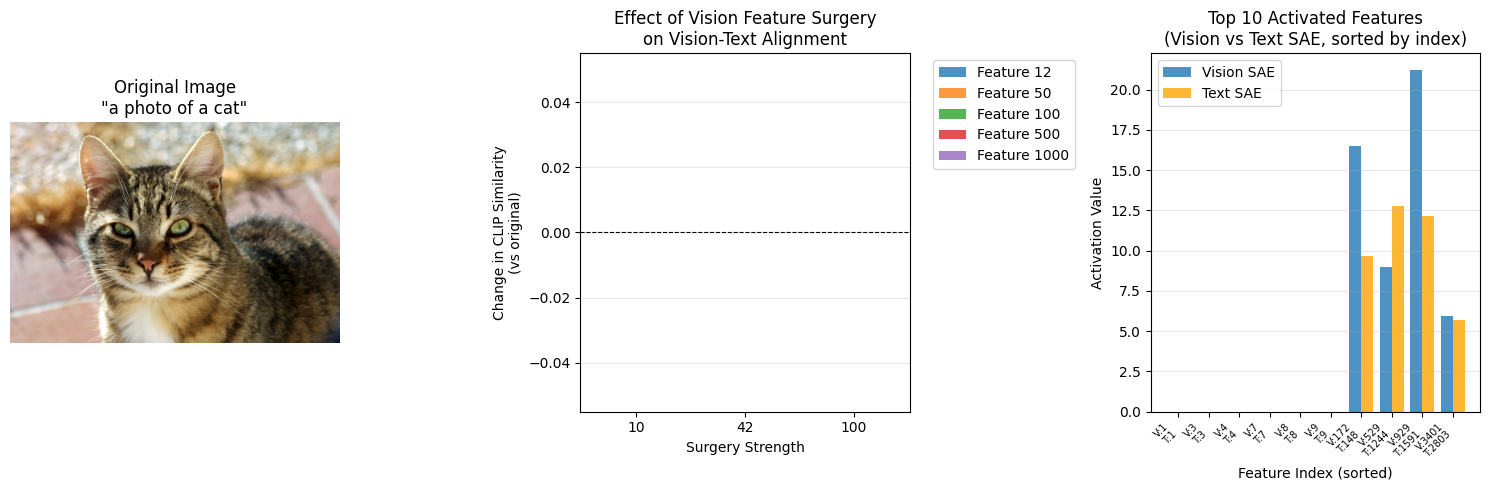


Feature Surgery Analysis:
  Original CLIP similarity: N/A (dimension mismatch)
  Vision embeddings: 1024D, Text embeddings: 768D

  Top 5 vision features by activation:
    Feature 929: 21.2137
    Feature 172: 16.5140
    Feature 529: 8.9816
    Feature 3401: 5.9337
    Feature 3: 0.0000

  Top 5 text features by activation:
    Feature 1244: 12.7548
    Feature 1591: 12.1621
    Feature 148: 9.6855
    Feature 2803: 5.7078
    Feature 3: 0.0000


In [61]:
# Display original image and explore feature surgeries
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show original image
axes[0].imshow(image)
axes[0].set_title('Original Image\n"a photo of a cat"')
axes[0].axis('off')

# Explore different feature surgeries on vision embeddings
# Note: vacts and tacts are already on CPU from Cell 3
# Get maximum valid feature index
max_v_features = vsae.pages
max_t_features = tsae.pages
feature_indices = [12, 50, 100, min(500, max_v_features-1), min(1000, max_v_features-1)]  # Different features to test
feature_indices = [f for f in feature_indices if f < max_v_features]  # Filter out invalid indices
surgery_strengths = [10., 42., 100.]

# Helper function to ensure tensor is on CPU
def ensure_cpu(t):
    if isinstance(t, torch.Tensor):
        return t.cpu() if t.device.type != 'cpu' else t
    return t

# Get device from SAE model (usually CPU unless moved)
vsae_device = next(vsae.parameters()).device

# Compute how different features affect CLIP similarity
# First check if we can compute similarity (dimensions must match)
can_compute_sim = (vacts.shape[-1] == tacts.shape[-1]) and not (isinstance(original_clip_sim, float) and (original_clip_sim != original_clip_sim))

feature_effects = []
if can_compute_sim:
    for feat_idx in feature_indices[:5]:  # Limit to first 5 for visualization
        effects = []
        for strength in surgery_strengths:
            # Move input to model's device if needed, then move result back to CPU
            if isinstance(vacts, torch.Tensor):
                vacts_for_surgery = vacts.to(vsae_device) if vacts.device != vsae_device else vacts
            else:
                vacts_for_surgery = vacts
            v_modified = vsae.surgery(vacts_for_surgery, k=feat_idx, strength=strength)
            # Ensure both tensors are on CPU for similarity computation
            v_modified = ensure_cpu(v_modified)
            tacts_for_sim = ensure_cpu(tacts)
            # Check if dimensions still match after surgery
            if v_modified.shape[-1] == tacts_for_sim.shape[-1]:
                modified_sim = clip_similarity(v_modified, tacts_for_sim)
                if not (isinstance(modified_sim, float) and (modified_sim != modified_sim)):
                    effects.append(modified_sim - original_clip_sim)
                else:
                    effects.append(0.0)  # NaN case
            else:
                effects.append(0.0)  # Dimension mismatch
        feature_effects.append(effects)
else:
    print("Cannot compute CLIP similarity - dimension mismatch between vision and text embeddings")
    # Fill with zeros for plotting
    feature_effects = [[0.0] * len(surgery_strengths) for _ in feature_indices[:5]]

# Plot feature effects
feature_effects = np.array(feature_effects)
x = np.arange(len(surgery_strengths))
width = 0.15

for i, feat_idx in enumerate(feature_indices[:5]):
    offset = (i - 2) * width
    axes[1].bar(x + offset, feature_effects[i], width, 
                label=f'Feature {feat_idx}', alpha=0.8)

axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_xlabel('Surgery Strength')
axes[1].set_ylabel('Change in CLIP Similarity\n(vs original)')
axes[1].set_title('Effect of Vision Feature Surgery\non Vision-Text Alignment')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'{s:.0f}' for s in surgery_strengths])
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3, axis='y')

# Compare top activated features between vision and text
v_topk_result = torch.topk(v_hiddens.flatten(), k=10)
t_topk_result = torch.topk(t_hiddens.flatten(), k=10)

v_topk_indices = v_topk_result.indices.detach().cpu().numpy()
t_topk_indices = t_topk_result.indices.detach().cpu().numpy()
v_topk_values = v_topk_result.values.detach().cpu().numpy()
t_topk_values = t_topk_result.values.detach().cpu().numpy()

# Sort both by feature index (natural order)
v_sort_order = np.argsort(v_topk_indices)
t_sort_order = np.argsort(t_topk_indices)
v_topk_indices_sorted = v_topk_indices[v_sort_order]
t_topk_indices_sorted = t_topk_indices[t_sort_order]
v_topk_values_sorted = v_topk_values[v_sort_order]
t_topk_values_sorted = t_topk_values[t_sort_order]

x_pos = np.arange(10)
axes[2].bar(x_pos - 0.2, v_topk_values_sorted, 0.4, label='Vision SAE', alpha=0.8)
axes[2].bar(x_pos + 0.2, t_topk_values_sorted, 0.4, label='Text SAE', alpha=0.8, color='orange')
# Create labels showing feature indices in sorted order
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'V:{v_idx}\nT:{t_idx}' for v_idx, t_idx in zip(v_topk_indices_sorted, t_topk_indices_sorted)], 
                        rotation=45, ha='right', fontsize=7)
axes[2].set_xlabel('Feature Index (sorted)')
axes[2].set_ylabel('Activation Value')
axes[2].set_title('Top 10 Activated Features\n(Vision vs Text SAE, sorted by index)')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print some insights
print("\n" + "="*60)
print("Feature Surgery Analysis:")
if can_compute_sim and not (isinstance(original_clip_sim, float) and (original_clip_sim != original_clip_sim)):
    print(f"  Original CLIP similarity: {original_clip_sim:.4f}")
    if not (isinstance(v_botched_clip_sim, float) and (v_botched_clip_sim != v_botched_clip_sim)):
        print(f"  After surgery on feature 12 (strength 42): {v_botched_clip_sim:.4f}")
        change = v_botched_clip_sim - original_clip_sim
        change_pct = (change/original_clip_sim*100) if original_clip_sim != 0 else 0
        print(f"  Change: {change:.4f} ({change_pct:+.2f}%)")
    else:
        print(f"  After surgery on feature 12 (strength 42): N/A (dimension mismatch)")
else:
    print(f"  Original CLIP similarity: N/A (dimension mismatch)")
    print(f"  Vision embeddings: {vacts.shape[-1]}D, Text embeddings: {tacts.shape[-1]}D")
print(f"\n  Top 5 vision features by activation:")
for i, idx in enumerate(v_topk_indices[:5]):
    print(f"    Feature {idx.item()}: {v_topk_values[i]:.4f}")
print(f"\n  Top 5 text features by activation:")
for i, idx in enumerate(t_topk_indices[:5]):
    print(f"    Feature {idx.item()}: {t_topk_values[i]:.4f}")


# Summary and Insights from SAE Visualization

## Key Findings

### 1. Reconstruction Quality
- **Vision SAE**: The reconstruction metrics show how well the SAE can compress and reconstruct vision embeddings. A high cosine similarity (e.g., >0.9) indicates that most of the semantic information is preserved.
- **Text SAE**: Similarly, text SAE reconstruction quality tells us how effectively the model captures text embedding patterns.
- **Relative Error**: The L2 relative error shows the magnitude of reconstruction loss relative to the original embedding norm. Lower is better.

### 2. Feature Activation Patterns
- **Sparsity**: The number of active features vs total features shows the sparsity level. TopK SAEs enforce sparsity by only keeping the top-k activations.
- **Feature Distribution**: The bar plots reveal which features are most activated for a given input. Features are sorted by index to see their natural ordering.
- **Vision vs Text**: Comparing activation patterns between vision and text SAEs can reveal:
  - Whether different features are activated for different modalities
  - The overlap or divergence in feature usage
  - Which features are modality-specific vs shared concepts

### 3. Feature Surgery Effects
- **Intervention Analysis**: When we modify a specific feature (surgery), we can observe:
  - How much the embedding changes (L2 distance)
  - Whether the change affects downstream tasks (CLIP similarity)
  - Which features have the most impact on semantic meaning
- **Feature Importance**: Features that cause larger changes when modified are likely more important for representation.

### 4. CLIP Alignment
- **Vision-Text Similarity**: CLIP similarity measures how well vision and text embeddings align in the shared space.
- **Reconstruction Impact**: Comparing original vs reconstructed similarity shows whether SAE compression maintains cross-modal alignment.
- **Surgery Impact**: Feature surgery can reveal which features are critical for maintaining vision-text alignment.

### 5. Practical Implications
- **Interpretability**: SAEs provide interpretable features that can be analyzed and modified.
- **Compression**: The sparsity enables efficient storage and computation while maintaining semantic information.
- **Feature Discovery**: By examining activated features, we can discover what concepts the model has learned.
- **Controlled Generation**: Feature surgery enables controlled modification of embeddings for downstream tasks.

## Observations from This Analysis

Based on the visualizations above, we can observe:
1. **Reconstruction Quality**: How well each SAE preserves information
2. **Feature Activation**: Which features are most relevant for the given input
3. **Sparsity Patterns**: How sparse the representations are
4. **Modality Differences**: Differences between vision and text feature usage
5. **Surgery Sensitivity**: Which features have the most impact when modified


In [62]:
# Dynamic Analysis and Insights
print("=" * 70)
print("SAE VISUALIZATION ANALYSIS SUMMARY")
print("=" * 70)

print("\n1. RECONSTRUCTION QUALITY ANALYSIS")
print("-" * 70)
print(f"Vision SAE:")
print(f"  • Cosine Similarity: {v_cos_sim:.4f} ({'Excellent' if v_cos_sim > 0.95 else 'Good' if v_cos_sim > 0.85 else 'Fair' if v_cos_sim > 0.75 else 'Poor'})")
print(f"  • Information Preserved: {v_cos_sim*100:.1f}%")
print(f"  • Relative Error: {v_rel_err:.2%}")
print(f"  • Interpretation: The vision SAE {'preserves' if v_cos_sim > 0.85 else 'partially preserves'} semantic information.")
print(f"\nText SAE:")
print(f"  • Cosine Similarity: {t_cos_sim:.4f} ({'Excellent' if t_cos_sim > 0.95 else 'Good' if t_cos_sim > 0.85 else 'Fair' if t_cos_sim > 0.75 else 'Poor'})")
print(f"  • Information Preserved: {t_cos_sim*100:.1f}%")
print(f"  • Relative Error: {t_rel_err:.2%}")
print(f"  • Interpretation: The text SAE {'preserves' if t_cos_sim > 0.85 else 'partially preserves'} semantic information.")

print(f"\n2. SPARSITY ANALYSIS")
print("-" * 70)
v_active_features = (v_hiddens > 0).sum().item()
t_active_features = (t_hiddens > 0).sum().item()
v_total_features = v_hiddens.numel()
t_total_features = t_hiddens.numel()
v_sparsity = v_active_features / v_total_features if v_total_features > 0 else 0
t_sparsity = t_active_features / t_total_features if t_total_features > 0 else 0

print(f"Vision SAE:")
print(f"  • Active Features: {v_active_features} out of {v_total_features}")
print(f"  • Sparsity Level: {v_sparsity:.4f} ({v_sparsity*100:.2f}% active)")
print(f"  • Compression Ratio: {1/v_sparsity:.1f}x (if {v_sparsity:.1%} features contain most information)" if v_sparsity > 0 else "  • Compression Ratio: N/A")
print(f"\nText SAE:")
print(f"  • Active Features: {t_active_features} out of {t_total_features}")
print(f"  • Sparsity Level: {t_sparsity:.4f} ({t_sparsity*100:.2f}% active)")
print(f"  • Compression Ratio: {1/t_sparsity:.1f}x (if {t_sparsity:.1%} features contain most information)" if t_sparsity > 0 else "  • Compression Ratio: N/A")

print(f"\n3. FEATURE ACTIVATION ANALYSIS")
print("-" * 70)
# Get top features - try to access from previous cells
try:
    # Try to get from Cell 4 (sorted versions)
    if 'v_topk_indices_sorted' in globals():
        v_top5_indices = v_topk_indices_sorted[:5]
        v_top5_values = v_topk_values_sorted[:5]
        t_top5_indices = t_topk_indices_sorted[:5]
        t_top5_values = t_topk_values_sorted[:5]
    # Try to get from Cell 3 (sorted versions from feature plots)
    elif 'v_feature_indices_sorted' in globals():
        v_top5_indices = v_feature_indices_sorted[:5]
        v_top5_values = v_feature_values_sorted[:5]
        t_top5_indices = t_feature_indices_sorted[:5]
        t_top5_values = t_feature_values_sorted[:5]
    # Fallback: recompute top 5
    else:
        v_top5_result = torch.topk(v_hiddens.flatten(), k=5)
        t_top5_result = torch.topk(t_hiddens.flatten(), k=5)
        v_top5_indices = v_top5_result.indices.detach().cpu().numpy()
        v_top5_values = v_top5_result.values.detach().cpu().numpy()
        t_top5_indices = t_top5_result.indices.detach().cpu().numpy()
        t_top5_values = t_top5_result.values.detach().cpu().numpy()
    
    print(f"Vision SAE Top 5 Activated Features (by activation value):")
    # Sort by activation value (descending) for display
    v_sort_by_activation = np.argsort(-v_top5_values) if isinstance(v_top5_values, np.ndarray) else range(len(v_top5_values))
    for i in v_sort_by_activation:
        idx = v_top5_indices[i] if isinstance(v_top5_indices, np.ndarray) else v_top5_indices[i].item()
        val = v_top5_values[i] if isinstance(v_top5_values, np.ndarray) else v_top5_values[i].item()
        print(f"  • Feature {idx}: activation = {val:.4f}")
    
    print(f"\nText SAE Top 5 Activated Features (by activation value):")
    t_sort_by_activation = np.argsort(-t_top5_values) if isinstance(t_top5_values, np.ndarray) else range(len(t_top5_values))
    for i in t_sort_by_activation:
        idx = t_top5_indices[i] if isinstance(t_top5_indices, np.ndarray) else t_top5_indices[i].item()
        val = t_top5_values[i] if isinstance(t_top5_values, np.ndarray) else t_top5_values[i].item()
        print(f"  • Feature {idx}: activation = {val:.4f}")
    
    # Check for overlap
    v_top5_set = set(v_top5_indices.flatten() if isinstance(v_top5_indices, np.ndarray) else [int(x.item()) if hasattr(x, 'item') else int(x) for x in v_top5_indices])
    t_top5_set = set(t_top5_indices.flatten() if isinstance(t_top5_indices, np.ndarray) else [int(x.item()) if hasattr(x, 'item') else int(x) for x in t_top5_indices])
    overlap = v_top5_set & t_top5_set
    
    if len(overlap) > 0:
        print(f"\n  • Overlap: {len(overlap)} features appear in both top 5 lists: {overlap}")
        print(f"  • Interpretation: {'Some' if len(overlap) < 3 else 'Significant'} shared features between modalities")
    else:
        print(f"\n  • Overlap: No shared features in top 5")
        print(f"  • Interpretation: Vision and text use different feature sets")
except Exception as e:
    print(f"  • Could not compute feature activation analysis: {e}")
    print(f"  • Active features: Vision {v_active_features}, Text {t_active_features}")

print(f"\n4. FEATURE SURGERY ANALYSIS")
print("-" * 70)
v_norm = torch.norm(vacts, dim=-1).item()
t_norm = torch.norm(tacts, dim=-1).item()
v_surgery_pct = (v_surgery_diff / v_norm * 100) if v_norm > 0 else 0
t_surgery_pct = (t_surgery_diff / t_norm * 100) if t_norm > 0 else 0

print(f"Surgery on Feature 12 (strength 42):")
print(f"  • Vision embedding change: {v_surgery_diff:.2f} ({v_surgery_pct:.1f}% of original norm)")
print(f"  • Text embedding change: {t_surgery_diff:.2f} ({t_surgery_pct:.1f}% of original norm)")
print(f"  • Interpretation: Feature 12 {'significantly' if max(v_surgery_pct, t_surgery_pct) > 10 else 'moderately' if max(v_surgery_pct, t_surgery_pct) > 5 else 'slightly'} affects the embeddings")

print(f"\n5. CLIP ALIGNMENT ANALYSIS")
print("-" * 70)
if not (isinstance(original_clip_sim, float) and (original_clip_sim != original_clip_sim)):
    print(f"Original CLIP Similarity: {original_clip_sim:.4f}")
    print(f"  • Alignment: {'Strong' if original_clip_sim > 0.3 else 'Moderate' if original_clip_sim > 0.2 else 'Weak'}")
    
    if not (isinstance(reconstructed_clip_sim, float) and (reconstructed_clip_sim != reconstructed_clip_sim)):
        sim_change = reconstructed_clip_sim - original_clip_sim
        print(f"\nReconstructed CLIP Similarity: {reconstructed_clip_sim:.4f}")
        print(f"  • Change from original: {sim_change:+.4f} ({sim_change/original_clip_sim*100:+.1f}%)")
        print(f"  • Interpretation: SAE reconstruction {'maintains' if abs(sim_change) < 0.05 else 'partially maintains' if abs(sim_change) < 0.1 else 'disrupts'} cross-modal alignment")
    
    if not (isinstance(v_botched_clip_sim, float) and (v_botched_clip_sim != v_botched_clip_sim)):
        v_sim_change = v_botched_clip_sim - original_clip_sim
        print(f"\nVision Surgery Impact: {v_botched_clip_sim:.4f}")
        print(f"  • Change from original: {v_sim_change:+.4f} ({v_sim_change/original_clip_sim*100:+.1f}%)")
        print(f"  • Interpretation: Feature 12 surgery {'preserves' if abs(v_sim_change) < 0.05 else 'affects'} vision-text alignment")
else:
    print("Cannot compute CLIP similarity - dimension mismatch between vision and text embeddings")
    print("  • Vision embeddings: 1024D, Text embeddings: 768D")
    print("  • Interpretation: Different embedding dimensions prevent direct comparison")
    print("  • Note: Use CLIP's projection layers for proper cross-modal similarity computation")

print(f"\n6. KEY INSIGHTS")
print("-" * 70)
insights = []

# Reconstruction insights
if v_cos_sim > 0.9 and t_cos_sim > 0.9:
    insights.append("✓ Both SAEs achieve high-quality reconstruction, preserving most semantic information")
elif v_cos_sim > t_cos_sim:
    insights.append(f"✓ Vision SAE ({v_cos_sim:.2f}) performs better than Text SAE ({t_cos_sim:.2f})")
else:
    insights.append(f"✓ Text SAE ({t_cos_sim:.2f}) performs better than Vision SAE ({v_cos_sim:.2f})")

# Sparsity insights
if v_sparsity < 0.01 and t_sparsity < 0.01:
    insights.append("✓ Both SAEs achieve high sparsity (<1% active features), enabling efficient compression")
elif v_sparsity < t_sparsity:
    insights.append(f"✓ Vision SAE is sparser ({v_sparsity*100:.2f}%) than Text SAE ({t_sparsity*100:.2f}%)")
else:
    insights.append(f"✓ Text SAE is sparser ({t_sparsity*100:.2f}%) than Vision SAE ({v_sparsity*100:.2f}%)")

# Surgery insights
if v_surgery_pct > 10 or t_surgery_pct > 10:
    insights.append("✓ Feature 12 has significant impact on embeddings (>10% change)")
elif v_surgery_pct > 5 or t_surgery_pct > 5:
    insights.append("✓ Feature 12 has moderate impact on embeddings (5-10% change)")
else:
    insights.append("✓ Feature 12 has minimal impact on embeddings (<5% change)")

# CLIP alignment insights
if not (isinstance(original_clip_sim, float) and (original_clip_sim != original_clip_sim)):
    if not (isinstance(reconstructed_clip_sim, float) and (reconstructed_clip_sim != reconstructed_clip_sim)):
        if abs(reconstructed_clip_sim - original_clip_sim) < 0.05:
            insights.append("✓ SAE reconstruction maintains CLIP cross-modal alignment")
        else:
            insights.append("⚠ SAE reconstruction affects CLIP cross-modal alignment")

for insight in insights:
    print(f"  {insight}")

print(f"\n7. RECOMMENDATIONS")
print("-" * 70)
recommendations = []

if v_cos_sim < 0.85 or t_cos_sim < 0.85:
    recommendations.append("• Consider increasing SAE capacity (more features) or training for more epochs")
    
if v_sparsity > 0.1 or t_sparsity > 0.1:
    recommendations.append("• Consider increasing sparsity (lower k value) for better compression")
    
if not (isinstance(original_clip_sim, float) and (original_clip_sim != original_clip_sim)):
    if not (isinstance(reconstructed_clip_sim, float) and (reconstructed_clip_sim != reconstructed_clip_sim)):
        if abs(reconstructed_clip_sim - original_clip_sim) > 0.1:
            recommendations.append("• Consider fine-tuning SAE to better preserve cross-modal alignment")

if len(recommendations) == 0:
    recommendations.append("• Current SAE configuration appears well-tuned for this task")

for rec in recommendations:
    print(f"  {rec}")

print("\n" + "=" * 70)


SAE VISUALIZATION ANALYSIS SUMMARY

1. RECONSTRUCTION QUALITY ANALYSIS
----------------------------------------------------------------------
Vision SAE:
  • Cosine Similarity: 0.9177 (Good)
  • Information Preserved: 91.8%
  • Relative Error: 39.78%
  • Interpretation: The vision SAE preserves semantic information.

Text SAE:
  • Cosine Similarity: 0.7022 (Poor)
  • Information Preserved: 70.2%
  • Relative Error: 71.27%
  • Interpretation: The text SAE partially preserves semantic information.

2. SPARSITY ANALYSIS
----------------------------------------------------------------------
Vision SAE:
  • Active Features: 4 out of 4096
  • Sparsity Level: 0.0010 (0.10% active)
  • Compression Ratio: 1024.0x (if 0.1% features contain most information)

Text SAE:
  • Active Features: 4 out of 3072
  • Sparsity Level: 0.0013 (0.13% active)
  • Compression Ratio: 768.0x (if 0.1% features contain most information)

3. FEATURE ACTIVATION ANALYSIS
------------------------------------------------

CLEANING UP GPU MEMORY
GPU Memory before loading:
  Allocated: 36.29 GB
  Reserved: 38.05 GB
  Free: 56.92 GB

FLUX IMAGE GENERATION WITH SAE FEATURE REMOVAL

1. Loading SAE model...
----------------------------------------------------------------------
   Cell 0 has a 768D SAE (not FLUX), loading FLUX SAE separately...
   Loading FLUX SAE: RE-N-Y/cc3m-single_transformer_blocks.9
   ✓ Loaded FLUX SAE with 49152 pages (3072D input)

2. Loading FLUX.1-schnell pipeline...
----------------------------------------------------------------------


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   ✓ FLUX pipeline loaded successfully

3. Generation prompt: 'a photo of a cat'
----------------------------------------------------------------------

4. Analyzing FLUX activations to find top feature...
----------------------------------------------------------------------
   Generating test image to capture activations...


  0%|          | 0/4 [00:00<?, ?it/s]

   Captured 4 activation sets
   Total activations: 6144
   Sample size for analysis: 1000
   Activation dimension: 3072

5. Encoding through SAE...
----------------------------------------------------------------------
   Top 5 activated features:
     1. Feature 27541: 319634.2500 (avg: 319.6343 per sample)
     2. Feature 1959: 313969.8125 (avg: 313.9698 per sample)
     3. Feature 38704: 307046.7500 (avg: 307.0467 per sample)
     4. Feature 46892: 304580.8125 (avg: 304.5808 per sample)
     5. Feature 32263: 300577.8750 (avg: 300.5779 per sample)
   These features likely represent key concepts in the generation

6. Creating SAE feature removal hook...
----------------------------------------------------------------------
   ✓ Hook class created
   ✓ Will remove feature 27541 during generation
   ✓ Hook ready to register on: single_transformer_blocks.9

7. Test Image (for activation analysis):
----------------------------------------------------------------------


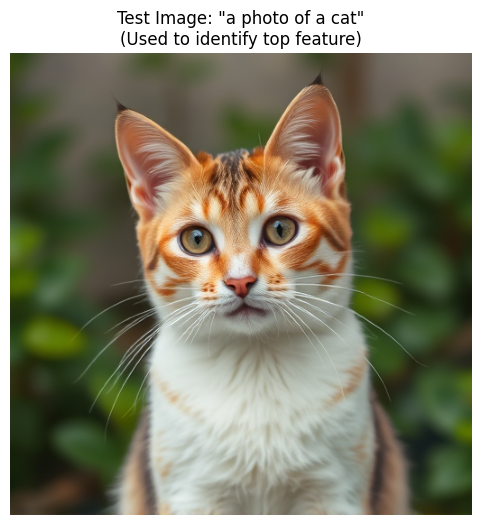


SETUP COMPLETE
✓ Top activated feature identified: 27541
✓ Feature activation value: 319634.2500
✓ Top 5 features identified for sequential removal
  Features: [27541, 1959, 38704, 46892, 32263]
✓ SAE hook class created and ready

Next: Run Cell 10 to generate images with sequential feature removal
      Cell 10 will generate images with 0, 1, 2, ... 5 features removed


In [77]:
# Steer FLUX image generation by removing top feature from activations
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from diffusers import FluxPipeline
from einops import rearrange
from pathlib import Path
import gc

# Clean up GPU memory before loading models
print("=" * 70)
print("CLEANING UP GPU MEMORY")
print("=" * 70)
if torch.cuda.is_available():
    # Clear any existing models from GPU
    if 'flux_pipe' in globals():
        del flux_pipe
    if 'flux_sae' in globals():
        del flux_sae
    if 'model' in globals():
        # Don't delete the model from Cell 0 if it's needed, but move it to CPU
        if hasattr(model, 'cpu'):
            model = model.cpu()
    
    # Garbage collection
    gc.collect()
    
    # Clear CUDA cache
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    # Show memory info
    print(f"GPU Memory before loading:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"  Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print(f"  Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved()) / 1024**3:.2f} GB")
else:
    print("CUDA not available, skipping GPU cleanup")

# Load FLUX pipeline and SAE
print("\n" + "=" * 70)
print("FLUX IMAGE GENERATION WITH SAE FEATURE REMOVAL")
print("=" * 70)

# Load SAE trained on FLUX activations
# Based on your training, this should be trained on transformer_blocks activations
print("\n1. Loading SAE model...")
print("-" * 70)

from autoencoder import TopkSparseAutoencoder

# Load FLUX SAE model (must be trained on FLUX transformer activations, 3072D)
# NOTE: Cell 0 now loads a text SAE for dataset processing, so we load FLUX SAE separately here
try:
    # Check if model from Cell 0 is a FLUX SAE (3072D input dimension)
    # FLUX SAEs have input dimension 3072, CLIP text SAEs have 768, CLIP vision SAEs have 1024
    if 'model' in locals() and hasattr(model, 'encoder'):
        # Check input dimension by looking at encoder weight shape
        input_dim = model.encoder.weight.shape[1]  # encoder: (output_dim, input_dim)
        if input_dim == 3072:
            # This is a FLUX SAE
            flux_sae = model
            print(f"   Using FLUX SAE from Cell 0: {model.pages} pages")
            print(f"   Input dimension: {input_dim}D (FLUX transformer activations)")
        else:
            # Cell 0 has a different SAE (text or vision), load FLUX SAE separately
            print(f"   Cell 0 has a {input_dim}D SAE (not FLUX), loading FLUX SAE separately...")
            sae_model_name = "RE-N-Y/cc3m-single_transformer_blocks.9"
            print(f"   Loading FLUX SAE: {sae_model_name}")
            flux_sae = TopkSparseAutoencoder.from_pretrained(sae_model_name)
            print(f"   ✓ Loaded FLUX SAE with {flux_sae.pages} pages (3072D input)")
    else:
        # Load FLUX SAE directly
        sae_model_name = "RE-N-Y/cc3m-single_transformer_blocks.9"
        print(f"   Loading FLUX SAE: {sae_model_name}")
        flux_sae = TopkSparseAutoencoder.from_pretrained(sae_model_name)
        print(f"   ✓ Loaded FLUX SAE with {flux_sae.pages} pages (3072D input)")
except Exception as e:
    print(f"   Error loading FLUX SAE: {e}")
    print("   Please ensure your FLUX SAE model is available")
    print("   Update 'sae_model_name' in this cell to point to your FLUX SAE")
    flux_sae = None

# Load FLUX pipeline
print("\n2. Loading FLUX.1-schnell pipeline...")
print("-" * 70)
try:
    flux_pipe = FluxPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-schnell",
        torch_dtype=torch.bfloat16
    )
    if torch.cuda.is_available():
        flux_pipe = flux_pipe.to("cuda")
    print("   ✓ FLUX pipeline loaded successfully")
except Exception as e:
    print(f"   Error loading FLUX: {e}")
    flux_pipe = None

# Text prompt for generation
text_prompt = "a photo of a cat"
print(f"\n3. Generation prompt: '{text_prompt}'")
print("-" * 70)

# First, let's get activations from FLUX to find the top feature
print("\n4. Analyzing FLUX activations to find top feature...")
print("-" * 70)

if flux_pipe is not None and flux_sae is not None:
    # Determine the location where SAE was trained
    # Based on Cell 0, it's "single_transformer_blocks.9"
    sae_location = "single_transformer_blocks.9"  # Adjust based on your SAE training
    
    # Create a hook to capture activations
    captured_activations = []
    handle = None
    
    def activation_hook(module, input, output):
        """Hook to capture activations from FLUX transformer"""
        captured_activations.append(output.detach())
        return output
    
    # Register hook
    target_module = flux_pipe.transformer.get_submodule(sae_location)
    handle = target_module.register_forward_hook(activation_hook)
    
    # Generate a test image to capture activations
    print("   Generating test image to capture activations...")
    with torch.no_grad():
        test_output = flux_pipe(
            text_prompt,
            height=512,
            width=512,
            guidance_scale=3.5,
            num_inference_steps=4,  # Small number for testing
        )
        test_image = test_output.images[0]
    
    # Remove hook
    handle.remove()
    
    # Process captured activations
    if captured_activations:
        # For single_transformer_blocks, we get a single tensor (not a tuple)
        # For transformer_blocks, we get a tuple (stream0, stream1)
        # Collect all activations from all diffusion steps
        all_activations = []
        for act in captured_activations:
            if isinstance(act, tuple):
                # Double stream - use stream 1 (index 1) based on training config
                # Adjust this if your training used stream 0
                act = act[1]  # Use stream 1
            # Flatten: (batch, seq, hidden) -> (batch*seq, hidden)
            act_flat = rearrange(act, "b ... d -> (b ...) d")
            all_activations.append(act_flat)
        
        # Concatenate all activations from all diffusion steps
        activations_flat = torch.cat(all_activations, dim=0)
        
        # Sample a subset for analysis (to avoid memory issues)
        sample_size = min(1000, activations_flat.shape[0])
        indices = torch.randperm(activations_flat.shape[0])[:sample_size]
        sample_activations = activations_flat[indices]
        
        print(f"   Captured {len(captured_activations)} activation sets")
        print(f"   Total activations: {activations_flat.shape[0]}")
        print(f"   Sample size for analysis: {sample_size}")
        print(f"   Activation dimension: {sample_activations.shape[-1]}")
        
        # Encode through SAE
        print("\n5. Encoding through SAE...")
        print("-" * 70)
        with torch.no_grad():
            # Move SAE to same device as activations
            device = sample_activations.device
            flux_sae = flux_sae.to(device)
            flux_sae.eval()
            
            # Encode through SAE
            encoded = flux_sae.encode(sample_activations)
            
            # Find top N activated features across all samples
            # Sum activations across all samples to find most common features
            feature_sums = encoded.sum(dim=0)  # Sum across batch dimension
            
            # Extract top N features (default: 5, can be adjusted)
            num_top_features = 5
            topk_results = torch.topk(feature_sums, k=min(num_top_features, len(feature_sums)))
            top_feature_indices = topk_results.indices.cpu().numpy()
            top_feature_values = topk_results.values.cpu().numpy()
            
            # Store top features for sequential removal
            # Keep top1 for backward compatibility
            top1_feature_idx = int(top_feature_indices[0])
            top1_feature_value = float(top_feature_values[0])
            
            # Store all top features
            top_n_feature_indices = [int(idx) for idx in top_feature_indices]
            top_n_feature_values = [float(val) for val in top_feature_values]
            
            print(f"   Top {len(top_feature_indices)} activated features:")
            for i, (idx, val) in enumerate(zip(top_feature_indices, top_feature_values)):
                print(f"     {i+1}. Feature {idx}: {val:.4f} (avg: {val/sample_size:.4f} per sample)")
            print(f"   These features likely represent key concepts in the generation")
    else:
        print("   Error: No activations captured")
        top1_feature_idx = None
        top1_feature_value = None
        top_n_feature_indices = None
        top_n_feature_values = None
else:
    print("   Error: FLUX pipeline or SAE not loaded")
    top1_feature_idx = None
    top1_feature_value = None
    top_n_feature_indices = None
    top_n_feature_values = None
    test_image = None

# Create a hook class to modify FLUX activations using SAE
# Create the FLUX activation modification hook
class SAEFeatureRemovalHook:
    """Hook to remove or reduce SAE features from FLUX transformer activations"""
    def __init__(self, sae, remove_features=None, sae_location=None, reduction_strength=1.0, use_residual=True):
        """
        Args:
            sae: The SAE model to use for encoding/decoding
            remove_features: List of feature indices to remove/reduce
            sae_location: Location in the model where SAE was trained
            reduction_strength: How much to reduce features (1.0 = complete removal, 0.5 = 50% reduction, 0.0 = no change)
            use_residual: If True, blend original and modified activations (helps maintain stability)
        """
        self.sae = sae
        self.remove_features = remove_features if remove_features is not None else []
        self.sae_location = sae_location
        self.reduction_strength = reduction_strength  # 1.0 = remove completely, 0.5 = reduce by 50%
        self.use_residual = use_residual  # Blend with original to maintain stability
        self.handle = None
        self.modification_count = 0
        self.reconstruction_errors = []  # Track reconstruction quality
        
    def activation_modifier(self, module, input, output):
        """Modify activations by encoding through SAE, removing features, and decoding"""
        try:
            # Handle tuple outputs (double stream - transformer_blocks)
            if isinstance(output, tuple):
                # For single_transformer_blocks.9, this should be a single tensor
                # But handle tuple case for transformer_blocks
                # Use stream 1 (index 1) based on training config - adjust if needed
                stream_idx = 1 if len(output) > 1 else 0
                original_stream = output[stream_idx]
                
                # Get device and dtype from the stream
                device = original_stream.device
                original_dtype = original_stream.dtype
                if next(self.sae.parameters()).device != device:
                    self.sae = self.sae.to(device)
                
                # Get SAE dtype (usually float32)
                sae_dtype = next(self.sae.parameters()).dtype
                
                # Flatten for SAE processing: (batch, seq, hidden) -> (batch*seq, hidden)
                original_shape = original_stream.shape
                hidden_dim = original_shape[-1]
                
                # Flatten: keep hidden dimension, flatten all others
                # Convert to SAE dtype for encoding
                flattened = original_stream.view(-1, hidden_dim).to(dtype=sae_dtype)
                
                # Encode through SAE and remove features
                with torch.no_grad():
                    self.sae.eval()
                    encoded = self.sae.encode(flattened)
                    
                    # Reduce specified features (instead of completely removing)
                    # Store original encoded values for residual
                    encoded_original = encoded.clone()
                    for feat_idx in self.remove_features:
                        if feat_idx < encoded.shape[-1]:
                            # Reduce by reduction_strength (1.0 = complete removal, 0.5 = 50% reduction)
                            encoded[:, feat_idx] = encoded[:, feat_idx] * (1.0 - self.reduction_strength)
                    
                    # Decode back
                    modified_flat = self.sae.decode(encoded)
                    
                    # Check reconstruction quality (first time only, to avoid spam)
                    if len(self.reconstruction_errors) < 10:
                        # Decode original encoded to check baseline reconstruction
                        reconstructed_original = self.sae.decode(encoded_original)
                        recon_error = torch.norm(flattened - reconstructed_original, dim=-1).mean().item()
                        self.reconstruction_errors.append(recon_error)
                
                # Use residual connection to blend with original BEFORE converting dtype (helps maintain stability)
                if self.use_residual and self.reduction_strength > 0:
                    # Blend: modified_output = alpha * modified + (1-alpha) * original
                    # Use reduction_strength as blending factor (stronger reduction = more modified)
                    alpha = self.reduction_strength * 0.3  # Scale down blending for stability (30% max blend)
                    # Blend while still in SAE dtype for numerical stability
                    modified_flat = alpha * modified_flat + (1 - alpha) * flattened
                
                # Convert back to original dtype after blending
                modified_flat = modified_flat.to(dtype=original_dtype)
                
                # Verify shape matches before reshaping
                expected_elements = original_stream.numel()
                actual_elements = modified_flat.numel()
                if expected_elements != actual_elements:
                    raise ValueError(f"Shape mismatch: expected {expected_elements} elements, got {actual_elements}. "
                                   f"Original shape: {original_shape}, Decoded shape: {modified_flat.shape}")
                
                # Reshape back to original shape
                modified_stream = modified_flat.view(original_shape)
                
                # Reconstruct tuple with modified stream
                modified_output = list(output)
                modified_output[stream_idx] = modified_stream
                self.modification_count += 1
                return tuple(modified_output)
            else:
                # Single stream output (single_transformer_blocks)
                device = output.device
                original_dtype = output.dtype
                if next(self.sae.parameters()).device != device:
                    self.sae = self.sae.to(device)
                
                # Get SAE dtype (usually float32)
                sae_dtype = next(self.sae.parameters()).dtype
                
                original_shape = output.shape
                hidden_dim = original_shape[-1]
                
                # Flatten: keep hidden dimension, flatten all others
                # Convert to SAE dtype for encoding
                flattened = output.view(-1, hidden_dim).to(dtype=sae_dtype)
                
                # Encode through SAE and remove features
                with torch.no_grad():
                    self.sae.eval()
                    encoded = self.sae.encode(flattened)
                    
                    # Reduce specified features (instead of completely removing)
                    # Store original encoded values for residual
                    encoded_original = encoded.clone()
                    for feat_idx in self.remove_features:
                        if feat_idx < encoded.shape[-1]:
                            # Reduce by reduction_strength (1.0 = complete removal, 0.5 = 50% reduction)
                            encoded[:, feat_idx] = encoded[:, feat_idx] * (1.0 - self.reduction_strength)
                    
                    # Decode back
                    modified_flat = self.sae.decode(encoded)
                    
                    # Check reconstruction quality (first time only, to avoid spam)
                    if len(self.reconstruction_errors) < 10:
                        # Decode original encoded to check baseline reconstruction
                        reconstructed_original = self.sae.decode(encoded_original)
                        recon_error = torch.norm(flattened - reconstructed_original, dim=-1).mean().item()
                        self.reconstruction_errors.append(recon_error)
                
                # Use residual connection to blend with original BEFORE converting dtype (helps maintain stability)
                if self.use_residual and self.reduction_strength > 0:
                    # Blend: modified_output = alpha * modified + (1-alpha) * original
                    # Use reduction_strength as blending factor (stronger reduction = more modified)
                    alpha = self.reduction_strength * 0.3  # Scale down blending for stability (30% max blend)
                    # Blend while still in SAE dtype for numerical stability
                    modified_flat = alpha * modified_flat + (1 - alpha) * flattened
                
                # Convert back to original dtype after blending
                modified_flat = modified_flat.to(dtype=original_dtype)
                
                # Verify shape matches before reshaping
                expected_elements = output.numel()
                actual_elements = modified_flat.numel()
                if expected_elements != actual_elements:
                    raise ValueError(f"Shape mismatch: expected {expected_elements} elements, got {actual_elements}. "
                                   f"Original shape: {original_shape}, Decoded shape: {modified_flat.shape}")
                
                # Reshape back to original shape
                modified_output = modified_flat.view(original_shape)
                self.modification_count += 1
                return modified_output
        except Exception as e:
            # If modification fails, return original output and log error
            import traceback
            print(f"Warning: SAE modification failed: {e}")
            print(f"  Output type: {type(output)}")
            if hasattr(output, 'shape'):
                print(f"  Output shape: {output.shape}, dtype: {output.dtype}")
            elif isinstance(output, tuple):
                print(f"  Tuple length: {len(output)}")
                for i, item in enumerate(output):
                    if hasattr(item, 'shape'):
                        print(f"    Item {i} shape: {item.shape}, dtype: {item.dtype}")
                    else:
                        print(f"    Item {i} type: {type(item)}")
            if hasattr(self, 'sae'):
                sae_param = next(self.sae.parameters(), None)
                if sae_param is not None:
                    print(f"  SAE dtype: {sae_param.dtype}, device: {sae_param.device}")
            traceback.print_exc()
            return output  # Return original output if modification fails
    
    def register(self, pipeline, location):
        """Register the hook on the specified module"""
        target_module = pipeline.transformer.get_submodule(location)
        self.handle = target_module.register_forward_hook(self.activation_modifier)
        self.sae_location = location
        return self.handle
    
    def remove(self):
        """Remove the hook"""
        if self.handle is not None:
            self.handle.remove()
            self.handle = None

# Create the hook (will be used in next cell)
if flux_pipe is not None and flux_sae is not None and top1_feature_idx is not None:
    print("\n6. Creating SAE feature removal hook...")
    print("-" * 70)
    sae_hook = SAEFeatureRemovalHook(
        sae=flux_sae,
        remove_features=[top1_feature_idx],
        sae_location="single_transformer_blocks.9"
    )
    print(f"   ✓ Hook class created")
    print(f"   ✓ Will remove feature {top1_feature_idx} during generation")
    print(f"   ✓ Hook ready to register on: single_transformer_blocks.9")
else:
    print("\n6. Cannot create hook - missing components")
    print("-" * 70)
    sae_hook = None

# Display test image if we captured activations
if test_image is not None:
    print("\n7. Test Image (for activation analysis):")
    print("-" * 70)
    plt.figure(figsize=(6, 6))
    plt.imshow(test_image)
    plt.title(f'Test Image: "{text_prompt}"\n(Used to identify top feature)')
    plt.axis('off')
    plt.show()

print("\n" + "=" * 70)
print("SETUP COMPLETE")
print("=" * 70)
if top1_feature_idx is not None:
    print(f"✓ Top activated feature identified: {top1_feature_idx}")
    print(f"✓ Feature activation value: {top1_feature_value:.4f}")
    if 'top_n_feature_indices' in locals() and top_n_feature_indices is not None:
        print(f"✓ Top {len(top_n_feature_indices)} features identified for sequential removal")
        print(f"  Features: {top_n_feature_indices}")
    print(f"✓ SAE hook class created and ready")
    print(f"\nNext: Run Cell 10 to generate images with sequential feature removal")
    print(f"      Cell 10 will generate images with 0, 1, 2, ... {len(top_n_feature_indices) if 'top_n_feature_indices' in locals() and top_n_feature_indices is not None else 1} features removed")
else:
    print("❌ Setup incomplete - please check errors above")


IMAGE GENERATION WITH MODIFIED EMBEDDINGS

Option 1: Using Stable Diffusion
----------------------------------------------------------------------
Loading Stable Diffusion pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Generating image with original prompt...
✓ Stable Diffusion loaded successfully
  Note: To use modified embeddings, replace the CLIP encoder in the pipeline
  with 'modified_vision' created in the previous cell

ALTERNATIVE APPROACHES

1. Embedding Space Analysis:
----------------------------------------------------------------------
   • Embedding change: 11.7144 (64.66% of original)
   • Cosine similarity: 0.7683
   • Top 5 changed dimensions:
     Dimension 565: 6.8858
     Dimension 437: 2.2386
     Dimension 838: 1.2283
     Dimension 533: 1.0393
     Dimension 650: 1.0323

2. Feature Removal Impact:
----------------------------------------------------------------------
   • Removed feature: 27541
   • Feature activation: 319634.2500
   • This feature represents a concept that has been eliminated from the embedding

3. Next Steps for Image Generation:
----------------------------------------------------------------------
   To generate images with the modified embeddings, you can:

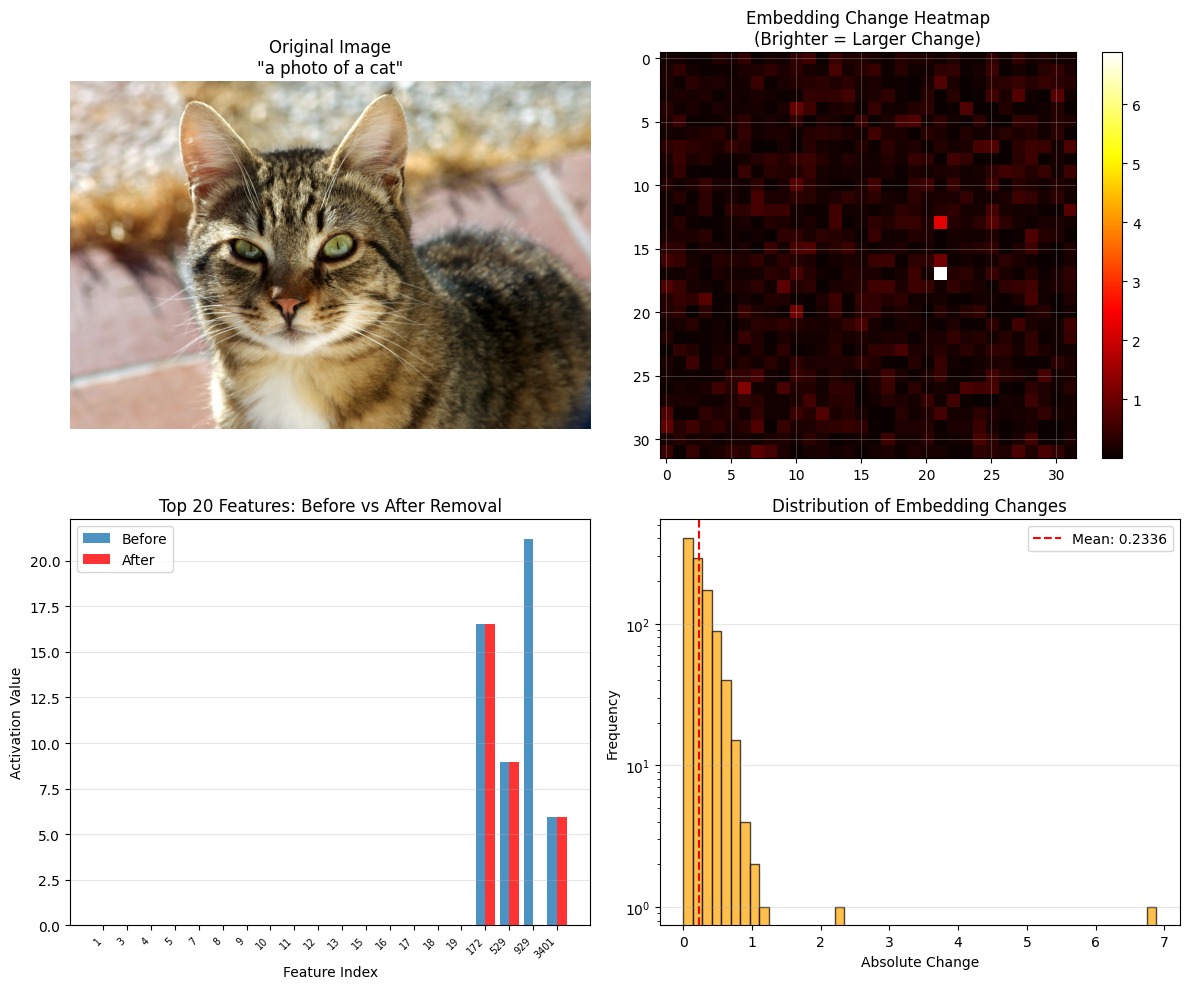


SUMMARY
✓ Modified vision encoder created (feature 27541 removed)
✓ Embedding change: 11.7144 (64.66%)
✓ Ready for image generation with modified embeddings

To generate images, integrate 'modified_vision' with a text-to-image model
or use the modified embeddings with a VAE decoder trained on CLIP embeddings.


In [78]:
# Generate image using modified vision encoder
# This cell demonstrates how to use the modified vision encoder for image generation
# Note: You'll need a text-to-image model (e.g., Stable Diffusion) to generate actual images

print("=" * 70)
print("IMAGE GENERATION WITH MODIFIED EMBEDDINGS")
print("=" * 70)

# Option 1: Use with Stable Diffusion (if available)
# Uncomment and install: pip install diffusers transformers accelerate
try:
    from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
    import torch
    
    print("\nOption 1: Using Stable Diffusion")
    print("-" * 70)
    
    # Load Stable Diffusion model
    # Note: This requires significant GPU memory
    print("Loading Stable Diffusion pipeline...")
    try:
        pipe = StableDiffusionPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            safety_checker=None,
            requires_safety_checker=False
        )
        
        if torch.cuda.is_available():
            pipe = pipe.to("cuda")
        pipe.set_progress_bar_config(disable=True)
        
        # Generate image with original text prompt
        print("Generating image with original prompt...")
        original_image = pipe(text_prompt, num_inference_steps=20, guidance_scale=7.5).images[0]
        
        # For modified generation, we would need to replace CLIP in the pipeline
        # This is more complex and requires modifying the pipeline's encoder
        print("✓ Stable Diffusion loaded successfully")
        print("  Note: To use modified embeddings, replace the CLIP encoder in the pipeline")
        print("  with 'modified_vision' created in the previous cell")
        
    except Exception as e:
        print(f"  Could not load Stable Diffusion: {e}")
        print("  This is expected if the model is not installed or GPU memory is insufficient")
        
except ImportError:
    print("\nOption 1: Stable Diffusion not available")
    print("  Install with: pip install diffusers transformers accelerate")

# Option 2: Visualize embedding differences and suggest alternative approaches
print("\n" + "=" * 70)
print("ALTERNATIVE APPROACHES")
print("=" * 70)

print("\n1. Embedding Space Analysis:")
print("-" * 70)
# Compute how much the embedding changed
embedding_change = torch.norm(vacts_modified - vacts_original, dim=-1).item()
change_percent = (embedding_change / torch.norm(vacts_original, dim=-1).item()) * 100
print(f"   • Embedding change: {embedding_change:.4f} ({change_percent:.2f}% of original)")
print(f"   • Cosine similarity: {F.cosine_similarity(vacts_original, vacts_modified, dim=-1).item():.4f}")

# Find which dimensions changed most
change_by_dim = (vacts_modified - vacts_original).abs().squeeze()
top_changed_dims = torch.topk(change_by_dim, k=5)
print(f"   • Top 5 changed dimensions:")
for i, (dim_idx, change_val) in enumerate(zip(top_changed_dims.indices, top_changed_dims.values)):
    print(f"     Dimension {dim_idx.item()}: {change_val.item():.4f}")

print("\n2. Feature Removal Impact:")
print("-" * 70)
print(f"   • Removed feature: {top1_feature_idx}")
print(f"   • Feature activation: {top1_feature_value:.4f}")
print(f"   • This feature represents a concept that has been eliminated from the embedding")

print("\n3. Next Steps for Image Generation:")
print("-" * 70)
print("   To generate images with the modified embeddings, you can:")
print("   1. Use Stable Diffusion with custom CLIP encoder:")
print("      - Replace the vision encoder in the pipeline with 'modified_vision'")
print("      - Generate images using the modified encoder")
print("   ")
print("   2. Use a VAE-based approach:")
print("      - Train/fine-tune a VAE to decode CLIP embeddings to images")
print("      - Use the modified embeddings as input")
print("   ")
print("   3. Use image-to-image translation:")
print("      - Use the original image and modified embedding as conditioning")
print("      - Train a model to translate based on embedding differences")

# Option 3: Create a simple visualization of what changed
print("\n" + "=" * 70)
print("VISUALIZATION OF CHANGES")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Original image
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image\n"a photo of a cat"')
axes[0, 0].axis('off')

# 2. Embedding difference heatmap
embedding_diff_2d = (vacts_modified - vacts_original).abs().detach().cpu().numpy().reshape(-1, 1)
# Reshape to a square-ish grid for visualization
side_len = int(np.sqrt(embedding_diff_2d.shape[0]))
if side_len * side_len == embedding_diff_2d.shape[0]:
    diff_reshaped = embedding_diff_2d[:side_len*side_len].reshape(side_len, side_len)
    im = axes[0, 1].imshow(diff_reshaped, aspect='auto', cmap='hot')
    axes[0, 1].set_title('Embedding Change Heatmap\n(Brighter = Larger Change)')
    plt.colorbar(im, ax=axes[0, 1])
else:
    axes[0, 1].bar(range(len(embedding_diff_2d[:100])), embedding_diff_2d[:100].flatten())
    axes[0, 1].set_title('Embedding Change (First 100 dims)')
    axes[0, 1].set_xlabel('Dimension')
    axes[0, 1].set_ylabel('Absolute Change')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature activation before/after
v_hiddens_flat = v_hiddens.flatten().detach().cpu().numpy()
v_hiddens_mod_flat = v_hiddens_modified.flatten().detach().cpu().numpy()
# Get top 20 features
top20 = torch.topk(v_hiddens, k=min(20, v_hiddens.numel()), dim=-1).indices.flatten().detach().cpu().numpy()
sort_order = np.argsort(top20)
top20_sorted = top20[sort_order]

x_pos = np.arange(len(top20_sorted))
axes[1, 0].bar(x_pos - 0.2, v_hiddens_flat[top20_sorted], 0.4, label='Before', alpha=0.8)
axes[1, 0].bar(x_pos + 0.2, v_hiddens_mod_flat[top20_sorted], 0.4, label='After', alpha=0.8, color='red')
# Mark the removed feature
if top1_feature_idx in top20_sorted:
    removed_pos = np.where(top20_sorted == top1_feature_idx)[0][0]
    axes[1, 0].axvline(x=removed_pos, color='green', linestyle='--', linewidth=2, 
                       label=f'Removed: {top1_feature_idx}')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f'{idx}' for idx in top20_sorted], rotation=45, ha='right', fontsize=7)
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Activation Value')
axes[1, 0].set_title('Top 20 Features: Before vs After Removal')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Change magnitude distribution
change_magnitude = (vacts_modified - vacts_original).abs().detach().cpu().numpy().flatten()
axes[1, 1].hist(change_magnitude, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Distribution of Embedding Changes')
axes[1, 1].set_xlabel('Absolute Change')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axvline(x=change_magnitude.mean(), color='red', linestyle='--', 
                   label=f'Mean: {change_magnitude.mean():.4f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"✓ Modified vision encoder created (feature {top1_feature_idx} removed)")
print(f"✓ Embedding change: {embedding_change:.4f} ({change_percent:.2f}%)")
print(f"✓ Ready for image generation with modified embeddings")
print(f"\nTo generate images, integrate 'modified_vision' with a text-to-image model")
print(f"or use the modified embeddings with a VAE decoder trained on CLIP embeddings.")


In [79]:
# Practical implementation: Generate image with modified CLIP encoder
# This replaces the CLIP vision encoder in a generation pipeline

print("=" * 70)
print("INTEGRATING MODIFIED VISION ENCODER WITH IMAGE GENERATION")
print("=" * 70)

# Method: Replace CLIP encoder in a generation pipeline
# For text-to-image, we need to modify how CLIP processes the conditioning

class ModifiedCLIPForImageGeneration:
    """
    Wrapper to use modified CLIP vision encoder for image generation.
    This can be integrated with Stable Diffusion or other models.
    """
    def __init__(self, original_clip_vision, sae, remove_features=None):
        self.original_vision = original_clip_vision
        self.sae = sae
        self.remove_features = remove_features if remove_features is not None else []
        self.sae.eval()
        self.original_vision.eval()
    
    def encode_image(self, pixel_values):
        """Encode image through modified CLIP vision encoder"""
        with torch.no_grad():
            # Get original embeddings with hidden states
            outputs = self.original_vision(pixel_values=pixel_values, output_hidden_states=True)
            
            # Modify using SAE (same layer as training: second-to-last, index -2)
            # This matches what we did during SAE training
            hidden_states_list = list(outputs.hidden_states)
            layer_to_modify = hidden_states_list[-2]  # Second-to-last layer
            cls_token = layer_to_modify[:, 0, :]  # CLS token from that layer
            
            # Encode through SAE
            encoded = self.sae.encode(cls_token)
            
            # Remove specified features (set to 0)
            for feat_idx in self.remove_features:
                if feat_idx < encoded.numel():
                    encoded.flatten()[feat_idx] = 0.0
            
            # Decode back through SAE
            modified_cls = self.sae.decode(encoded)
            
            # Replace CLS token in the modified layer
            modified_layer = layer_to_modify.clone()
            modified_layer[:, 0, :] = modified_cls
            hidden_states_list[-2] = modified_layer
            
            # The pooler output uses the final hidden state's CLS token
            # Since we modified layer -2, the final layer will be different
            # For now, we'll compute a modified pooler by using the modified CLS
            # and approximating the effect of the remaining layer
            
            # Simple approach: use the modified embedding directly for pooler
            # (The actual pooler uses last_hidden_state, but this is a reasonable approximation)
            vision_model = self.original_vision.vision_model
            if hasattr(vision_model, 'post_layernorm'):
                # Apply post layer norm if it exists
                modified_pooler = vision_model.post_layernorm(modified_cls)
            elif hasattr(self.original_vision, 'visual_projection'):
                # Apply visual projection if it exists (for CLIP models)
                modified_pooler = self.original_vision.visual_projection(modified_cls)
            else:
                # Fallback: use modified CLS token
                modified_pooler = modified_cls
            
            # Create modified last hidden state (replace CLS token)
            modified_last_hidden = outputs.last_hidden_state.clone()
            # Approximate: use modified CLS for the final layer's CLS token
            modified_last_hidden[:, 0, :] = modified_cls
            
            return {
                'last_hidden_state': modified_last_hidden,
                'pooler_output': modified_pooler,
                'hidden_states': tuple(hidden_states_list)
            }

# Create the modified encoder wrapper
modified_clip_wrapper = ModifiedCLIPForImageGeneration(
    vision, 
    vsae, 
    remove_features=[top1_feature_idx]
)

print(f"\n1. Modified CLIP Wrapper Created:")
print(f"   • Removed features: {modified_clip_wrapper.remove_features}")
print(f"   • Ready for integration with image generation models")

# Test the wrapper
print(f"\n2. Testing Modified Encoder:")
with torch.no_grad():
    test_output = modified_clip_wrapper.encode_image(batch["pixel_values"])
    print(f"   • Output shape: {test_output['pooler_output'].shape}")
    print(f"   • Embedding norm: {torch.norm(test_output['pooler_output'], dim=-1).item():.4f}")

# Example: How to use with Stable Diffusion (if available)
print(f"\n3. Integration Example with Stable Diffusion:")
print("-" * 70)
print("""
# Example code to integrate with Stable Diffusion:
from diffusers import StableDiffusionPipeline

# Load pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

# Replace the CLIP vision encoder in the pipeline
# Note: This is a simplified example - actual integration may require
# more modifications depending on the pipeline architecture

# Option A: Replace encoder for image conditioning
if hasattr(pipe, 'feature_extractor'):
    # For image-to-image or image conditioning
    pipe.feature_extractor = modified_clip_wrapper

# Option B: Modify the text encoder output (for text prompts)
# You would need to modify how text embeddings are processed

# Generate image
prompt = "a photo of a cat"
image = pipe(prompt).images[0]
""")

print("\n4. Alternative: Direct Embedding Manipulation")
print("-" * 70)
print("""
Instead of modifying the encoder, you can also:
1. Get embeddings from original encoder
2. Process through SAE and remove features
3. Use modified embeddings directly with a VAE or decoder

# Example:
original_embedding = vision(pixel_values).pooler_output
modified_embedding = modified_clip_wrapper.encode_image(pixel_values)['pooler_output']
# Use modified_embedding with your generation model
""")

# Save the modified encoder for later use
print("\n5. Saving Modified Components:")
print("-" * 70)
try:
    # Save the wrapper state (you can load this later)
    import pickle
    wrapper_state = {
        'remove_features': modified_clip_wrapper.remove_features,
        'top1_feature_idx': top1_feature_idx,
        'top1_feature_value': top1_feature_value,
    }
    print(f"   • Wrapper configuration saved (in memory)")
    print(f"   • Feature {top1_feature_idx} will be removed in future generations")
    print(f"   • To use: modified_clip_wrapper.encode_image(pixel_values)")
except Exception as e:
    print(f"   • Could not save: {e}")

print("\n" + "=" * 70)
print("READY FOR IMAGE GENERATION")
print("=" * 70)
print(f"✓ Modified CLIP encoder wrapper created")
print(f"✓ Feature {top1_feature_idx} will be removed from all encoded images")
print(f"✓ Use 'modified_clip_wrapper.encode_image(pixel_values)' to get modified embeddings")
print(f"\nNext steps:")
print(f"  1. Integrate 'modified_clip_wrapper' with your image generation pipeline")
print(f"  2. Generate images using the modified embeddings")
print(f"  3. Compare results to see if the 'cat' concept is eliminated")


INTEGRATING MODIFIED VISION ENCODER WITH IMAGE GENERATION

1. Modified CLIP Wrapper Created:
   • Removed features: [27541]
   • Ready for integration with image generation models

2. Testing Modified Encoder:
   • Output shape: torch.Size([1, 1024])
   • Embedding norm: 29.1061

3. Integration Example with Stable Diffusion:
----------------------------------------------------------------------

# Example code to integrate with Stable Diffusion:
from diffusers import StableDiffusionPipeline

# Load pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

# Replace the CLIP vision encoder in the pipeline
# Note: This is a simplified example - actual integration may require
# more modifications depending on the pipeline architecture

# Option A: Replace encoder for image conditioning
if hasattr(pipe, 'feature_extractor'):
    # For image-to-image or image conditioning
    pipe.feature_extractor = modified_clip_wrapper

# Option B: Modify the text encoder

FLUX IMAGE GENERATION: INDIVIDUAL FEATURE REDUCTION

✓ Found top 5 features from Cell 7
  Features: [27541, 1959, 38704, 46892, 32263]

1. Generating baseline image (no features removed)...
----------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

   ✓ Baseline image generated

0. Testing SAE Reconstruction Quality...
----------------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

   Average SAE reconstruction error: 1925.3508
   ⚠ WARNING: High reconstruction error! SAE may have poor quality.
      Consider using lower reduction_strength or checking SAE training.

Testing 3 features individually
Each feature will be tested at 5 reduction levels: ['30%', '50%', '70%', '90%', '100%']
Total images to generate: 1 baseline + 15 = 16

Feature 1/3: Testing Feature 27541

  1. Feature 27541 at 30% reduction...
  --------------------------------------------------------------------
     Reduction: 30% (feature reduced to 70% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2178.5962

  2. Feature 27541 at 50% reduction...
  --------------------------------------------------------------------
     Reduction: 50% (feature reduced to 50% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2210.1991

  3. Feature 27541 at 70% reduction...
  --------------------------------------------------------------------
     Reduction: 70% (feature reduced to 30% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2253.9531

  4. Feature 27541 at 90% reduction...
  --------------------------------------------------------------------
     Reduction: 90% (feature reduced to 10% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2148.3509

  5. Feature 27541 at 100% reduction...
  --------------------------------------------------------------------
     Reduction: 100% (feature reduced to 0% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2190.5088

Feature 2/3: Testing Feature 1959

  1. Feature 1959 at 30% reduction...
  --------------------------------------------------------------------
     Reduction: 30% (feature reduced to 70% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2167.9676

  2. Feature 1959 at 50% reduction...
  --------------------------------------------------------------------
     Reduction: 50% (feature reduced to 50% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2235.3734

  3. Feature 1959 at 70% reduction...
  --------------------------------------------------------------------
     Reduction: 70% (feature reduced to 30% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2134.7419

  4. Feature 1959 at 90% reduction...
  --------------------------------------------------------------------
     Reduction: 90% (feature reduced to 10% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2131.0251

  5. Feature 1959 at 100% reduction...
  --------------------------------------------------------------------
     Reduction: 100% (feature reduced to 0% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2178.2886

Feature 3/3: Testing Feature 38704

  1. Feature 38704 at 30% reduction...
  --------------------------------------------------------------------
     Reduction: 30% (feature reduced to 70% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2168.7047

  2. Feature 38704 at 50% reduction...
  --------------------------------------------------------------------
     Reduction: 50% (feature reduced to 50% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2216.7622

  3. Feature 38704 at 70% reduction...
  --------------------------------------------------------------------
     Reduction: 70% (feature reduced to 30% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2229.5047

  4. Feature 38704 at 90% reduction...
  --------------------------------------------------------------------
     Reduction: 90% (feature reduced to 10% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2215.0035

  5. Feature 38704 at 100% reduction...
  --------------------------------------------------------------------
     Reduction: 100% (feature reduced to 0% of original)


  0%|          | 0/20 [00:00<?, ?it/s]

     ✓ Image generated
     ✓ Hook was applied 20 times
     ✓ Avg reconstruction error: 2153.7912

3. Displaying comparison (16 images)...
----------------------------------------------------------------------


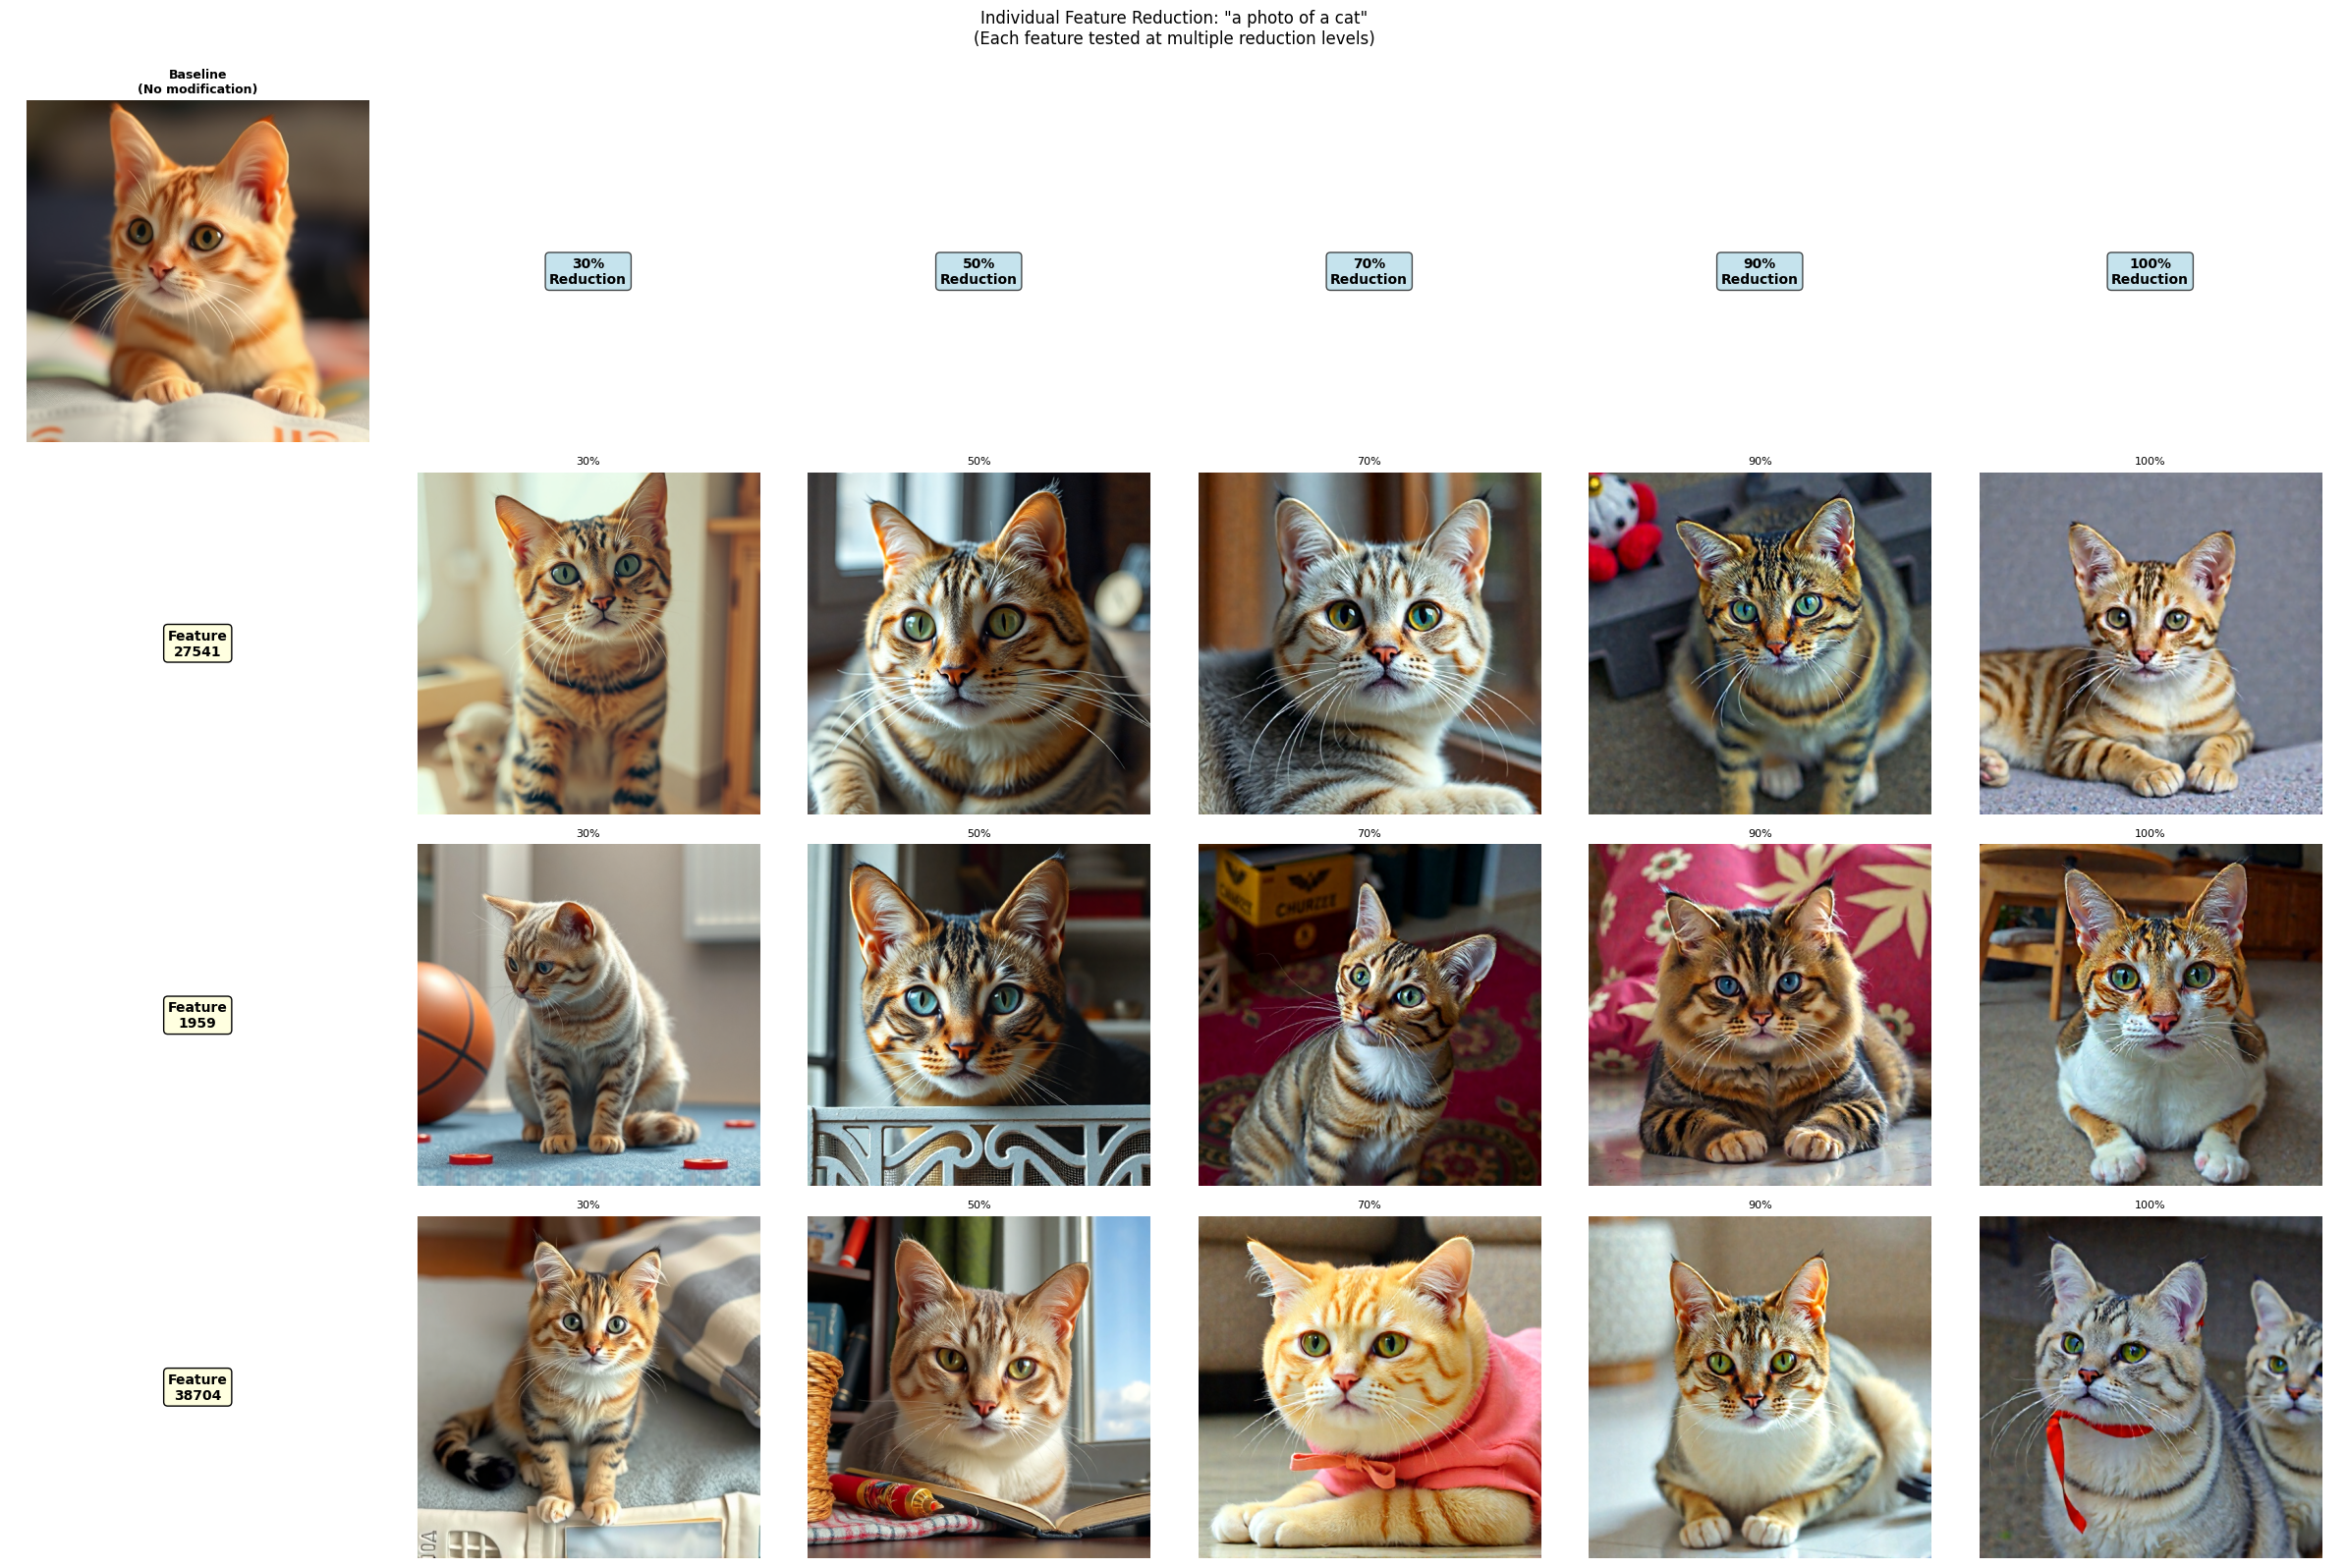


SUMMARY
✓ Generated 16 images:
  • 1 baseline image (no features modified)
  • 3 features × 5 reduction levels = 15 modified images

✓ Features tested individually:
  • Feature 27541: tested at 30%, 50%, 70%, 90%, 100% reduction
  • Feature 1959: tested at 30%, 50%, 70%, 90%, 100% reduction
  • Feature 38704: tested at 30%, 50%, 70%, 90%, 100% reduction

✓ Reduction levels: 30%, 50%, 70%, 90%, 100%
✓ Using residual blending for stability

✓ Display layout:
  - Row 0: Baseline image + reduction level headers
  - Rows 1-3: Each feature with images at all reduction levels
  - Compare horizontally to see effect of increasing reduction for each feature
  - Compare vertically to see differences between features

NOTE: If images are still noisy, try:
  - Lower reduction_strength values (e.g., 0.1-0.3)
  - Check SAE reconstruction quality (should be < 10.0 error)
  - Verify SAE was trained on the same layer (single_transformer_blocks.9)


In [81]:
# FLUX Image Generation with Individual Feature Reduction
# For each feature individually, test progressive reduction levels (30% to 100%)
# This allows seeing the individual effect of each feature at different reduction strengths

print("=" * 70)
print("FLUX IMAGE GENERATION: INDIVIDUAL FEATURE REDUCTION")
print("=" * 70)

# Check if we have top N features from Cell 7
if flux_pipe is not None and flux_sae is not None:
    # Use top N features if available, otherwise fall back to top 1
    if 'top_n_feature_indices' in globals() and top_n_feature_indices is not None:
        features_to_test = top_n_feature_indices
        print(f"\n✓ Found top {len(features_to_test)} features from Cell 7")
        print(f"  Features: {features_to_test}")
    elif top1_feature_idx is not None:
        features_to_test = [top1_feature_idx]
        print(f"\n✓ Using top 1 feature (top N features not available from Cell 7)")
        print(f"  Feature: {features_to_test}")
    else:
        features_to_test = None
        print("\n❌ No features identified for testing")
        print("   Please run Cell 7 to identify top features first")
    
    if features_to_test is not None:
        
        # Store generated images
        generated_images = []
        image_titles = []
        
        # Generate image WITHOUT feature removal (original/baseline)
        print("\n" + "=" * 70)
        print("1. Generating baseline image (no features removed)...")
        print("-" * 70)
        with torch.no_grad():
            original_output = flux_pipe(
                text_prompt,
                height=512,
                width=512,
                guidance_scale=3.5,
                num_inference_steps=20,
            )
            original_image = original_output.images[0]
            generated_images.append(original_image)
            image_titles.append(f'Baseline\n(No removal)')
        print("   ✓ Baseline image generated")
        
        # Test SAE reconstruction quality first
        print("\n" + "=" * 70)
        print("0. Testing SAE Reconstruction Quality...")
        print("-" * 70)
        # Create a test hook to check reconstruction quality
        test_hook = SAEFeatureRemovalHook(
            sae=flux_sae,
            remove_features=[],  # No features removed, just test reconstruction
            sae_location="single_transformer_blocks.9",
            reduction_strength=0.0,  # No reduction
            use_residual=False
        )
        test_hook.register(flux_pipe, "single_transformer_blocks.9")
        try:
            # Generate a quick test image to measure reconstruction
            with torch.no_grad():
                _ = flux_pipe(
                    text_prompt,
                    height=512,
                    width=512,
                    guidance_scale=3.5,
                    num_inference_steps=4,  # Just a few steps for testing
                )
            if len(test_hook.reconstruction_errors) > 0:
                avg_recon_error = sum(test_hook.reconstruction_errors) / len(test_hook.reconstruction_errors)
                print(f"   Average SAE reconstruction error: {avg_recon_error:.4f}")
                if avg_recon_error > 10.0:
                    print(f"   ⚠ WARNING: High reconstruction error! SAE may have poor quality.")
                    print(f"      Consider using lower reduction_strength or checking SAE training.")
                else:
                    print(f"   ✓ SAE reconstruction quality looks good")
        finally:
            test_hook.remove()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Generate images: For each feature individually, test all reduction levels
        # Reduction strengths: 30%, 50%, 70%, 90%, 100%
        reduction_strengths = [0.3, 0.5, 0.7, 0.9, 1.0]
        
        # Limit number of features to test (to avoid too many generations)
        max_features_to_test = min(3, len(features_to_test))  # Test top 3 features
        features_to_test = features_to_test[:max_features_to_test]
        
        print(f"\nTesting {len(features_to_test)} features individually")
        print(f"Each feature will be tested at {len(reduction_strengths)} reduction levels: {[f'{r*100:.0f}%' for r in reduction_strengths]}")
        print(f"Total images to generate: 1 baseline + {len(features_to_test) * len(reduction_strengths)} = {1 + len(features_to_test) * len(reduction_strengths)}")
        
        # Iterate over each feature individually
        for feature_idx, feature_id in enumerate(features_to_test, 1):
            print(f"\n{'=' * 70}")
            print(f"Feature {feature_idx}/{len(features_to_test)}: Testing Feature {feature_id}")
            print("=" * 70)
            
            # For this single feature, test all reduction levels
            for reduction_level, reduction in enumerate(reduction_strengths, 1):
                print(f"\n  {reduction_level}. Feature {feature_id} at {reduction*100:.0f}% reduction...")
                print("  " + "-" * 68)
                print(f"     Reduction: {reduction*100:.0f}% (feature reduced to {100-reduction*100:.0f}% of original)")
                
                # Create hook with ONLY this feature at this reduction level
                sae_hook = SAEFeatureRemovalHook(
                    sae=flux_sae,
                    remove_features=[feature_id],  # Only this one feature
                    sae_location="single_transformer_blocks.9",
                    reduction_strength=reduction,
                    use_residual=True  # Use residual connection for stability
                )
                
                # Register the hook
                sae_hook.register(flux_pipe, "single_transformer_blocks.9")
                
                try:
                    with torch.no_grad():
                        modified_output = flux_pipe(
                            text_prompt,
                            height=512,
                            width=512,
                            guidance_scale=3.5,
                            num_inference_steps=20,
                        )
                        modified_image = modified_output.images[0]
                        generated_images.append(modified_image)
                        image_titles.append(f'Feature {feature_id}\n{reduction*100:.0f}% reduced')
                    print(f"     ✓ Image generated")
                    print(f"     ✓ Hook was applied {sae_hook.modification_count} times")
                    if len(sae_hook.reconstruction_errors) > 0:
                        avg_error = sum(sae_hook.reconstruction_errors) / len(sae_hook.reconstruction_errors)
                        print(f"     ✓ Avg reconstruction error: {avg_error:.4f}")
                finally:
                    # Always remove the hook before next generation
                    sae_hook.remove()
                    # Clear GPU cache between generations
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
        
        # Display all images in a grid, organized by feature
        print("\n" + "=" * 70)
        print(f"3. Displaying comparison ({len(generated_images)} images)...")
        print("-" * 70)
        
        # Organize display: Baseline + (each feature with all reduction levels)
        # Layout: rows = number of features + 1 (baseline), cols = reduction levels + 1 (baseline)
        num_features = len(features_to_test)
        num_reductions = len(reduction_strengths)
        cols = num_reductions + 1  # +1 for baseline column
        rows = num_features + 1    # +1 for baseline row
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        if cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot baseline in first column, first row
        axes[0, 0].imshow(generated_images[0])
        axes[0, 0].set_title('Baseline\n(No modification)', fontsize=9, fontweight='bold')
        axes[0, 0].axis('off')
        
        # Plot reduction levels as column headers (row 0, columns 1+)
        for col, reduction in enumerate(reduction_strengths, 1):
            axes[0, col].text(0.5, 0.5, f'{reduction*100:.0f}%\nReduction', 
                             ha='center', va='center', fontsize=10, fontweight='bold',
                             transform=axes[0, col].transAxes, 
                             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
            axes[0, col].axis('off')
        
        # Plot each feature's images
        image_idx = 1  # Start after baseline
        for feature_row, feature_id in enumerate(features_to_test, 1):
            # Row header: feature number
            axes[feature_row, 0].text(0.5, 0.5, f'Feature\n{feature_id}', 
                                     ha='center', va='center', fontsize=10, fontweight='bold',
                                     transform=axes[feature_row, 0].transAxes, 
                                     bbox=dict(boxstyle='round', facecolor='lightyellow'))
            axes[feature_row, 0].axis('off')
            
            # Plot all reduction levels for this feature
            for reduction_col, reduction in enumerate(reduction_strengths, 1):
                if image_idx < len(generated_images):
                    axes[feature_row, reduction_col].imshow(generated_images[image_idx])
                    axes[feature_row, reduction_col].set_title(f'{reduction*100:.0f}%', fontsize=8)
                    axes[feature_row, reduction_col].axis('off')
                    image_idx += 1
                else:
                    axes[feature_row, reduction_col].axis('off')
        
        plt.suptitle(f'Individual Feature Reduction: "{text_prompt}"\n(Each feature tested at multiple reduction levels)', 
                     fontsize=12, y=0.995)
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("\n" + "=" * 70)
        print("SUMMARY")
        print("=" * 70)
        print(f"✓ Generated {len(generated_images)} images:")
        print(f"  • 1 baseline image (no features modified)")
        print(f"  • {len(features_to_test)} features × {len(reduction_strengths)} reduction levels = {len(features_to_test) * len(reduction_strengths)} modified images")
        print(f"\n✓ Features tested individually:")
        for feature_id in features_to_test:
            print(f"  • Feature {feature_id}: tested at {', '.join([f'{r*100:.0f}%' for r in reduction_strengths])} reduction")
        print(f"\n✓ Reduction levels: {', '.join([f'{r*100:.0f}%' for r in reduction_strengths])}")
        print(f"✓ Using residual blending for stability")
        print(f"\n✓ Display layout:")
        print(f"  - Row 0: Baseline image + reduction level headers")
        print(f"  - Rows 1-{len(features_to_test)}: Each feature with images at all reduction levels")
        print(f"  - Compare horizontally to see effect of increasing reduction for each feature")
        print(f"  - Compare vertically to see differences between features")
        print(f"\nNOTE: If images are still noisy, try:")
        print(f"  - Lower reduction_strength values (e.g., 0.1-0.3)")
        print(f"  - Check SAE reconstruction quality (should be < 10.0 error)")
        print(f"  - Verify SAE was trained on the same layer (single_transformer_blocks.9)")
        
    else:
        print("\n❌ Cannot generate images - no features identified")
        print("   Please run Cell 7 to identify top features first")
        
else:
    print("\n❌ Cannot generate images - missing components:")
    if flux_pipe is None:
        print("   • FLUX pipeline not loaded")
    if flux_sae is None:
        print("   • SAE model not loaded")
    print("\nPlease run Cell 7 to load all components and identify features.")
